In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from util import load_metric
from scipy.stats import spearmanr, pearsonr, zscore, rankdata
import matplotlib.pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
import statsmodels.formula.api as smf

#from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [3]:
pd.set_option('display.expand_frame_repr', False)

In [4]:
pd.set_option('display.max_columns', None)

## FUNCTIONS

### Utils

In [5]:
def jaccard(a, b):
    return len(a.intersection(b)) / len(a.union(b))

In [6]:
def v_renamer(var_string):
    var_string = var_string.split("_")
    yi, yj     = tuple(var_string[-1].split(":"))
    yi         = yi[-2:]
    yj         = yj[-2:]
    return f"{yi}:{yj}"

In [7]:
def read_csv(path):
    return pd.read_csv(path, sep=";", index_col=0)

In [8]:
def get_dwts(df, path):
    with open(Path(path), "r") as f:
        dwt_roots = [w.strip("\n") for w in f.readlines()]
    dwt_regex = re.compile(f"({'|'.join(dwt_roots)})")    
    dwts = [str(w) for w in df.index if re.search(dwt_regex, str(w)) != None]
    return dwts    

In [9]:
def get_variables(df):
    """
    Summeraises variables of a dataframe
    """
    
    yr_prefix = set()
    tr_prefix = set()
    years = set()
    transitions = set()
    
    for v in df.columns:
        prefix, suffix = tuple(v.split("_"))
        if ":" in suffix:
            tr_prefix.add(prefix)
            transitions.add(suffix)
        else:
            yr_prefix.add(prefix)
            years.add(suffix)
    
    return {
        "yr_prefix": yr_prefix, 
        "tr_prefix": tr_prefix,
        "years": years,
        "transitions": transitions
        }    

In [10]:
def find_transitions(source, mode="file", var = None):
    """
    List transitions. 
    For mode = "file", expected source: filepath
    For mode = "df", expected source: pandas DataFrame; provide varible var
    """
    if mode == "file":
        years = [int(file.strip(".txt")) for file in os.listdir(source)]
        years.sort()
        transitions = [(year, years[i]) for i, year in enumerate(years[:-1], start=1)]
    if mode == "df":
        cols = [col for col in source.columns if col.startswith(var)]
        cols.sort()
        transitions = [tuple(col.split("_")[-1].split(":")) for col in cols]
    return transitions

In [11]:
def nonaninf(x, y):
    if pd.isna(x):
        return False
    if pd.isna(y):
        return False   
    if abs(x) == np.inf:
        return False
    if abs(y) == np.inf:
        return False
    return True

In [12]:
def nonalist(lst):
    for x in lst:
        if pd.isna(x):
            return False
    return True

### Debugging

In [13]:
def collect_var(df, var, varcut, include_labels=False):
    X = []
    labels = []
    varcol = sorted([col for col in df.columns if col.startswith(var)])
    if varcut != None:
        del varcol[varcut]
    #print(varcol)
    for col in varcol:
        X.extend(list(df[col]))
        labels.extend(df.index)
    if include_labels:
        return X, labels
    else:
        return X    

In [14]:
def w_overlap_checker(corpus, th_c):
    
    corpus = Path(corpus)
    transitions = find_transitions(corpus / "vocab")
    
    for yi, yj in transitions:
        print()
        print(f"{yi}:{yj}")
        
        voc_a = load_metric(corpus / f"vocab/{yi}.txt")
        voc_b = load_metric(corpus / f"vocab/{yj}.txt")

        voc_a = {w: c for w, c in voc_a.items() if c >= th_c}
        voc_b = {w: c for w, c in voc_b.items() if c >= th_c}
        print(f"{yi}:", len(voc_a))
        print(f"{yj}:", len(voc_b))
        print(f"{yi} and {yj}:", len([w for w in voc_a.keys() if w in voc_b.keys()]))
        print(f"{yi} or {yj}:", len(set(voc_a.keys()).union(set(voc_b.keys()))))
        print(f"{yi} - {yj}:", len(set(voc_a.keys()).difference(set(voc_b.keys()))))

In [15]:
def checker(word, transition, controls_dir, n_ctrl=10, variable="cosine_change"):
    """
    Goes to original data, shows the control change/similarity of a word 
    at a transition.
    param word
    param transition    tupple of ti and tj 
    param controls_dir  where to find controls
    param variable      "cosine_change" or "cosine_sim"
    """
    
    ti, tj = transition
    basename = Path(controls_dir) / variable 
    
    filenames = [f"{ti}_{tj}_control{n}.txt" for n in range(1, n_ctrl+1)]
    
    values = []
    
    for file in filenames:
        data = load_metric(basename / file)
        value = data[word] if word in data else "NO MEASURE"
        values.append(value)
        print(file, value)
        
    return values   

In [16]:
def ncd(DATA, CORPUS, VAR, VAL): # No Change Detector

    corpus = Path(CORPUS)
    transitions = find_transitions(corpus / "vocab")    

    for yi, yj in transitions:
        print()
        print(f"{yi}:{yj}")
        
        A = list(DATA[DATA[f"{VAR}_{yi}:{yj}"] == VAL].index)
        print("No change (A):", len(A))
        B = list(DATA[DATA[f"{VAR}_{yi}:{yj}"] != VAL].index)
        print("Other (B):", len(B))
        print()
        print("{: <20} {}".format("A", "B"))
        print("{: <20} {}".format("---", "---"))
        for w1, w2 in zip(A[:100], B[:100]):
            print(f"{w1: <20} {w2}")

### Main functions

In [17]:
def q_show(df, var, k = 40, as_table = False, transition=True, min_freq=None, return_md=False):
    """
    Given a dataframe, shows the top k words for variable var each year.
    Note: as_table only sypported for transition variables!
    """
    
    COLUMNS = [col for col in sorted(df.columns) if col.startswith(var)]

    if min_freq == None:    
        WORDS = [df[col].sort_values(ascending=False)[:k].index for col in COLUMNS]
    else:
        TRANSITIONS = [tuple(col.split("_")[-1].split(":")) for col in COLUMNS]
        WORDS = [df[(df[f"frq_{trs[0]}"] >= min_freq) & (df[f"frq_{trs[1]}"] >= min_freq)][col].sort_values(ascending=False)[:k].index for col, trs in zip(COLUMNS, TRANSITIONS)]
    
    ser = [(c, d) for c, d in zip(COLUMNS, WORDS)]
    
    md = ""
    
    for i, (col, s) in enumerate(ser):
        if i > 0:
            jac = round(jaccard(set(s), ser[i-1][-1]), 2)
        else:
            jac = None
        
        print(); md += "\n"
        print(col, "jaccard =", jac); md += f"{col} jaccard = {jac}"

        if transition:
            if as_table == False:
                print(s)
            else:
                trans  = col.split("_")[-1]
                ti, tj = tuple(trans.split(":"))
                table  = [] 
                for word in s:
                    v    = df.loc[word][col]
                    f_ti = int(df.loc[word][f"frq_{ti}"])
                    f_tj = int(df.loc[word][f"frq_{tj}"])
                    gch  = df.loc[word][f"gch_{trans}"]
                    m    = df.loc[word][f"mccc_{trans}"]
                    std  = df.loc[word][f"stdc_{trans}"]
                    columns = ["Word", var.upper(), "n_i", "n_j", "GCH", "Mctrl", "Sctrl"]
                    table.append([word, v, f_ti, f_tj, gch, m, std])
                print(pd.DataFrame(table, columns=columns).dropna().round(3))
                md += pd.DataFrame(table, columns=columns).dropna().round(3).to_markdown()
        
        else:
            year = col.split("_")[-1]
            table = []
            for word in s:
                v    = df.loc[word][col]
                f = int(df.loc[word][f"frq_{year}"])
                columns = ["Word", var.upper(), "Freq"]
                table.append([word, v, f])
            print(pd.DataFrame(table, columns=columns).dropna().round(3))
            md += pd.DataFrame(table, columns=columns).dropna().round(3).to_markdown()
    if return_md:
        return md

In [18]:
def change_show(df, var, targets, th=4.781, return_md = False, min_freq=10):
    """
    Given a dataframe, shows the value for a variable of target 
    each transition/year.
    Provide threshold to only show the targets meeting the threshold
    """
    
    md = ""

    for col in sorted([col for col in df.columns if col.startswith(var)]):
        trans  = col.split("_")[-1]
        ti, tj = tuple(trans.split(":"))
        table  = [] 
        
        for word in targets:
            v    = df.loc[word][col]
            f_ti = int(df.loc[word][f"frq_{ti}"])
            f_tj = int(df.loc[word][f"frq_{tj}"])
            if min_freq != None:
                if f_ti < min_freq or f_tj < min_freq:
                    continue
            gch  = df.loc[word][f"gch_{trans}"]
            m    = df.loc[word][f"mccc_{trans}"]
            std  = df.loc[word][f"stdc_{trans}"]            
            
            if th != None:
                if v > th:
                    table.append([word, v, f_ti, f_tj, gch, m, std])
            else:
                table.append([word, v, f_ti, f_tj, gch, m, std])
        
        columns = ["Word", "Value", f"n_{ti}", f"n_{tj}", f"gch_{ti}:{tj}", f"M_{ti}:{tj}", f"Std_{ti}:{tj}"]
        if table != []:
            display = pd.DataFrame(table, columns=columns)
            print(); md += "\n" 
            print(col); md += f"{col}\n"
            print(display); md += display.to_markdown()
    
    if return_md:
        return md

In [19]:
def overview(
    df, 
    var, 
    targets,
    verbose = False,
    prefixes = ("N", "A", "V"), 
    th=4.781,
    reverse_th=False,
    transition = True, 
    min_freq = 10, 
    return_md = False,
    rounder = 3,
    return_complex=False
):
    """ 
    Similar to change_show but:
    * Show data as one table
    * Only show variable (change_show display additional data)
    * Provide th to show True/False
    """
    
    cols = sorted([col for col in df.columns if col.startswith(var)])
    targets = [w for w in targets if w.startswith(prefixes)]
    targets.sort()
    if transition:
        renamer = {k: v_renamer(k) for k in cols}
    else:
        renamer = {k: k.split("_")[-1][-2:] for k in cols}
    
    
    
    if min_freq != None and transition:
        df = df.copy()
        transitions = find_transitions(df, "df", var)
        for trg in targets:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    #df.at[trg, f"{var}_{ti}:{tj}"] = 0
                    df.at[trg, f"{var}_{ti}:{tj}"] = np.nan

    if min_freq != None and transition == False:
        df = df.copy()
        years = sorted([int(col.split("_")[-1]) for col in cols])
        for trg in targets:
            for year in years:
                if df.loc[trg][f"frq_{year}"] < min_freq:
                    df.at[trg, f"{var}_{year}"] = 0        
    
    out = df.loc[targets, cols]
    out.rename(columns = renamer, inplace = True)
    
    if return_complex:
        redef_out = []
        #out = out.apply(three_values(th=th))
#         print(out)
#         print([[y[-1] for y in x.tolist] for x in out.iterrows()])
    
        for word, row in out.iterrows():
            this_row = []
            #print(row)
            for cell in row:
                #print(cell, type(cell))
                if pd.isna(cell):
                    cell = None
                else:
                    if reverse_th:
                        if cell < th:
                            cell = 1
                        else:
                            cell = 0                        
                        
                    else:    
                        if cell > th:
                            cell = 1
                        else:
                            cell = 0
                
                this_row.append(cell)
            redef_out.append(this_row)
        out = pd.DataFrame(redef_out, index=targets, columns = cols)
        out.rename(columns = renamer, inplace = True)
        
    else:
        if th != None:
            #print(df.loc[targets, cols])
            #out = df.loc[targets, cols] > th
            if reverse_th:
                out = out < th
            else:
                out = out > th

        else:
            #out = df.loc[targets, cols].round(rounder)
            out = out.round(rounder)

    if verbose:
        print(var.upper())
        print(out) 
        print("SUM:", out.sum().sum())            
            
    if return_md:
        md = ""
        md += var.upper() + "\n"
        md += out.to_markdown()
        md += f"\nSUM: {out.sum().sum()}\n"
        return md
    else: 
        return out

In [20]:
def layered_view(
    dfs, 
    names = ["A1", "A2", "A3"], 
    as_pandas=True, 
    numerical=False, 
    spc_labels=False, 
    ignore_NA = False,
    ignore_pos = False
):
    
    #Create empty table
    n_rows, n_cols = dfs[0].shape
    n_cols = n_cols + 1
    table = [[[] for j in range(n_cols)] for i in range(n_rows)]
    #print(table)

    # Add first column = the words
    terms = dfs[0].index
    if ignore_pos:
        terms = ["_".join(term.split("_")[1:]) for term in terms]
    for i, word in enumerate(terms):
        table[i][0].append(word)
        #print(table)

    # Update cells
    names = ["A1", "A2", "A3"]
    for name, df in zip(names, dfs):
        if ignore_pos:
            assert [row[0][0] for row in table] == ["_".join(idx.split("_")[1:]) for idx in df.index]
        else:
            assert [row[0][0] for row in table] == list(df.index)
        for i, (word, row) in enumerate(df.iterrows()):
            for j, cell in enumerate(row, start=1):
                # None (when expected freq < 5), NaN (when freq < 10), 1 (sign.), 0 (non-sign.)
                if cell == 1:
                    table[i][j].append(name)
                if cell == None:
                    table[i][j].append(f"X-{name}")
                    continue
                if pd.isna(cell):
                    table[i][j].append(f"NA-{name}")

    table = [[",".join(cell) for cell in row] for row in table]
    
    #Some replacements:
    table = [[cell.replace("NA-A1,NA-A2,X-A3", "NA") for cell in row] for row in table]
    table = [[cell.replace("NA-A1,NA-A2,NA-A3", "NA") for cell in row] for row in table]
    table = [[cell.replace("NA-A1,NA-A3", "NA") for cell in row] for row in table]
    table = [[cell.replace(",NA-A3", "") for cell in row] for row in table]
    table = [[cell.replace("NA-A3", "") for cell in row] for row in table]
    table = [[cell.replace("NA-A1", "") for cell in row] for row in table]
    table = [[cell.replace(",X-A3", "~") for cell in row] for row in table]
    table = [[cell.replace("X-A3", "~") for cell in row] for row in table]
    table = [[cell.replace("A1,A2", "AVG") for cell in row] for row in table]
    table = [[cell.replace("A2,A3", "BERT") for cell in row] for row in table]
    if ignore_NA:
        table = [[cell.replace("NA", "") for cell in row] for row in table]
    
    #Convet to numerical (no. of sign.)
    if numerical:
        table = [[0 if cell == "NA"   else cell for cell in row] for row in table]
        table = [[1 if cell == ""     else cell for cell in row] for row in table]
        table = [[1 if cell == "~"    else cell for cell in row] for row in table]
        table = [[2 if cell == "A2~"  else cell for cell in row] for row in table]
        table = [[2 if cell == "A2"   else cell for cell in row] for row in table]
        table = [[3 if cell == "AVG"  else cell for cell in row] for row in table]
        if spc_labels:
            table = [[4 if cell == "BERT" else cell for cell in row] for row in table]
        else:
            table = [[3 if cell == "BERT" else cell for cell in row] for row in table]
    
    if as_pandas:
        table = pd.DataFrame(
            data = [row[1:] for row in table], 
            index = [row[0] for row in table], 
            columns=dfs[0].columns
        )
        renamer = {k: v_renamer(k) for k in dfs[0].columns}
        table.rename(columns = renamer, inplace = True)
    
    return table


In [21]:
def heated_layer(dfs, distinguish_BERT_from_AVG = True, ignore_pos=False):
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    
    my_df_num = layered_view(dfs, numerical=True, spc_labels=distinguish_BERT_from_AVG, ignore_pos=ignore_pos).sort_index()
    my_df_lbl = layered_view(dfs, ignore_NA=True, ignore_pos=ignore_pos).sort_index()
    
    y = 6
    x = y*2

    plt.figure(figsize=(x, y), dpi=300)

    # Check:
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html
    # param of pcolor can be used to draw grid

    #colors_list = ['#FF5733', '#FFC300']
    if distinguish_BERT_from_AVG:
        colors_list = ["darkgrey", "white", "yellow", "yellowgreen", "orange"]
        cmap = colors.ListedColormap(colors_list)
        plt.pcolor(my_df_num, cmap = cmap, edgecolors = "k")
    else:
        plt.pcolor(my_df_num, cmap = 'Greens')


    plt.yticks(np.arange(0.5, len(my_df_num.index), 1), my_df_num.index)
    plt.xticks(np.arange(0.5, len(my_df_num.columns), 1), my_df_num.columns, rotation=45)

    n_rows, n_cols = my_df_num.shape

    for i in range(n_rows):
        for j in range(n_cols):
            text = plt.text(j+0.5, i+0.5, my_df_lbl.iloc[i][j], ha="center", va="center", color="k")

    #for line in range(n_cols):
    #    plt.axvline(line, color="black", linestyle="dashed", linewidth=0.5)

    #for line in range(n_rows):
    #    plt.axhline(line, color="black", linestyle="dashed", linewidth=0.5)

    #plt.grid(which="major", color="k", linestyle='--', linewidth=1)
    plt.show()

In [22]:
def trend(df, var, norm=None, transition = True, metric="pearson", prefixes = ("N", "A", "V")):
    
    if transition:
        T = find_transitions(source=df, mode = "df", var=var)
    else:
        cols = [col for col in df.columns if col.startswith(var)]
        cols.sort()
        T = [int(col.split("_")[-1]) for col in cols]

    Y = [n for n in range(len(T))]
    table = []
    for w in df.index:
        
        if prefixes != None:
            if not w.startswith(prefixes):
                continue
        
        if transition:
            X = df[[f"{var}_{ti}:{tj}" for ti, tj in T]].loc[w]
        else:
            X = df[[f"{var}_{t}" for t in T]].loc[w]
        
        
        valid = [(x, y) for x, y in zip(X, Y) if not pd.isna(x)]

        N = len(valid)

        if N < 2:
            v = np.nan
            p = np.nan
        else:
            X, Y = zip(*valid)
            if norm != None:
                X = norm(X)

            if metric == "pearson":
                R_data = pearsonr(X, Y)

            if metric == "spearman":
                R_data = spearmanr(X, Y)
                
            v = R_data.statistic
            p = R_data.pvalue

        table.append([w, round(v, 3), round(p, 5), N])
    correlation = pd.DataFrame(table, columns=["Word", "Trend", "p", "N"])
        
    return correlation
    

In [23]:
def correlation(
    df, 
    var1,
    var2, 
    mode=1,
    varcutter=False, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="pearson",
    min_freq = 11 ### OBS!
):    
    """
    
    ...
    param norm1  function to normalize/transform var1 with (default None); provide function 
                 e.g. zscore or np.log 
    """

    transitions1 = find_transitions(df, "df", var1)
    transitions2 = find_transitions(df, "df", var2)
    
    if min_freq != None:
        df = df.copy()
        
        for trg in [w for w in df.index]:
            for ti, tj in transitions2:
                if df.loc[trg][f"frq_{ti}"] <= min_freq or df.loc[trg][f"frq_{tj}"] <= min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan

    if mode == 1:
        correlation = df[[f"{var1}_{ti}:{tj}" for ti, tj in transitions]].corrwith(df[[f"{var2}_{ti}:{tj}" for ti, tj in transitions]], axis=1)
    
    if mode == 2:
        table = []
        for w in df.index:
            valid = []
            if varcutter:
                X = df[[f"{var1}_{t[0]}" for t in transitions1]].loc[w]
                #print(X)
                X = X[:-1] # <-- Obs!
            else:
                X = df[[f"{var1}_{ti}:{tj}" for ti, tj in transitions1]].loc[w]
            
            
                
            Y = df[[f"{var2}_{ti}:{tj}" for ti, tj in transitions2]].loc[w]
            for x, y in zip(X, Y):
                if pd.isna(x):
                    continue
                if pd.isna(y):
                    continue
                valid.append((x, y))
            
            N = len(valid)
            
            if N < 2:
                v = np.nan
                p = np.nan
            else:
                X, Y = zip(*valid)
                
                if prenorm1 != None:
                    X = prenorm1(X)
                if prenorm2 != None:
                    Y = prenorm2(Y)                
                
                if norm1 != None:
                    X = norm1(X)
                if norm2 != None:
                    Y = norm2(Y)
                    
                X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])

                if metric == "pearson":
                    R_data = pearsonr(X, Y)
                    v = R_data.statistic
                    p = R_data.pvalue

                if metric == "spearman":
                    R_data = spearmanr(X, Y)
                    v = R_data.statistic
                    p = R_data.pvalue
                    
            table.append([w, round(v, 3), round(p, 3), N])
        correlation = pd.DataFrame(table, columns=["Word", "Correlation", "p", "N"])
        
    return correlation

In [24]:
def universal_correlation(
    df, 
    var1, # X
    var2, # Y
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = None,
    top_cut_off=None,
    min_freq = None, # for large dataframes this is un-usable, as implemented below (iteration)
    verbose=False
):
    # https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas
    
    if top_n != None:
        df = df.copy()
        if top_cut_off != None:
            df = df.sort_values(by=['tot_frq'], ascending=False)[top_cut_off:top_n]
        else:
            df = df.sort_values(by=['tot_frq'], ascending=False)[:top_n]
        #print(df)
    
    if min_freq != None:
        df = df.copy()
        
        t1 = find_transitions(df, "df", var1)
        t2 = find_transitions(df, "df", var2)
        
        if var1cut != None:
            transitions = [t for t in t2]
            if verbose: 
                print("transitions", transitions)
        else:
            transitions = [t for t in t1]
        

        for trg in [w for w in df.index]:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan
    
    X = collect_var(df, var1, var1cut)
    Y = collect_var(df, var2, var2cut)
    
#     if verbose:
#         print("Length:")
#         print("X:", len(X))
#         print("Y:", len(Y))
    
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])

    if prenorm1 != None:
        X = prenorm1(X)
    if prenorm2 != None:
        Y = prenorm2(Y) 
    
    if norm1 != None:
        X = norm1(X)
    if norm2 != None:
        Y = norm2(Y)
    
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])

    if verbose:
        print("Length:")
        print("X:", len(X))
        print("Y:", len(Y))    
    
    if metric == "pearson":
        R_data = pearsonr(X, Y)
    if metric == "spearman":
        R_data = spearmanr(X, Y)
    if metric == "OLS":
        model = smf.ols("Y ~ X", data=pd.DataFrame({"X": X, "Y": Y}))
        #model = sm.OLS(Y, X)
        #X = sm.add_constant(X) # https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS
        results = model.fit()
        print(results.summary())
        
        residuals = results.resid # residuals
        fig = sm.qqplot(residuals)
        plt.show()
        return model
    
    v = R_data.statistic
    p = R_data.pvalue
    
    return v, p

### Visualization

In [25]:
def vis_u_cor(
    df, 
    var1, 
    var2, 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    top_n = None,
    top_cut_off = None,
    min_freq = None,
    alpha=0.5,
    ymax=None
):
    # https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas
    
    if top_n != None:
        df = df.copy()
        if top_cut_off != None:
            df = df.sort_values(by=['tot_frq'], ascending=False)[top_cut_off:top_n]
        else:
            df = df.sort_values(by=['tot_frq'], ascending=False)[:top_n]
        #print(df)
    
    if min_freq != None:
        df = df.copy()
        
        t1 = find_transitions(df, "df", var1)
        t2 = find_transitions(df, "df", var2)
        
        if var1cut != None:
            transitions = [t for t in t2]
            print("transitions", transitions)
        else:
            transitions = [t for t in t1]
        

        for trg in [w for w in df.index]:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan
    
    X = collect_var(df, var1, var1cut)
    Y = collect_var(df, var2, var2cut)
            
#     print("Length:")
#     print("X:", len(X))
#     print("Y:", len(Y))
    
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])
    
    print("Length:")
    print("X:", len(X))
    print("Y:", len(Y))    
        
    if norm1 != None:
        X = norm1(X)
    if norm2 != None:
        Y = norm2(Y)
    
    if ymax != None:
        plt.ylim(ymax = ymax, ymin=-ymax)
    plt.scatter(X, Y, alpha=alpha)
    plt.show()    

In [26]:
def vis_u_cor_with_labels(
    df, 
    var1, 
    var2, 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    top_n = None,
    top_cut_off = None,
    min_freq = None,
    alpha=0.5, 
    group=None
):
    # https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas
    
    if top_n != None:
        df = df.copy()
        if top_cut_off != None:
            df = df.sort_values(by=['tot_frq'], ascending=False)[top_cut_off:top_n]
        else:
            df = df.sort_values(by=['tot_frq'], ascending=False)[:top_n]
        #print(df)
    
    if min_freq != None:
        df = df.copy()
        
        t1 = find_transitions(df, "df", var1)
        t2 = find_transitions(df, "df", var2)
        
        if var1cut != None:
            transitions = [t for t in t2]
            print("transitions", transitions)
        else:
            transitions = [t for t in t1]
        

        for trg in [w for w in df.index]:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan
    
    X, labels = collect_var(df, var1, var1cut, include_labels=True)
    Y, _labels = collect_var(df, var2, var2cut, include_labels=True)
    
    assert labels == _labels
            
#     print("Length:")
#     print("X:", len(X))
#     print("Y:", len(Y))
    
    X, Y, labels = zip(*[(x, y, label) for x, y, label in zip(X, Y, labels) if nonaninf(x,y)])
    
    if group != None:
        for g in group:
            g_name = ", ".join(g)
            labels = [g_name if label in g else label for label in labels]
        
        labels = ["Other" if "," not in label else label for label in labels]
                    
    
    label2key = {label: idx for idx, label in enumerate(set(labels))}
    key2label = {idx: label for label, idx in label2key.items()}
    
    labels = [label2key[label] for label in labels]
    
    print("Length:")
    print("X:", len(X))
    print("Y:", len(Y))    
        
    if norm1 != None:
        X = norm1(X)
    if norm2 != None:
        Y = norm2(Y)
    
    # Redefine labels??!
    # 
    
    #scat=plt.scatter(X, Y, c=labels, alpha=alpha)
    #plt.legend(*scat.legend_elements(), loc="lower left", title="Classes")
    
    plt.figure(figsize=(10, 10), dpi=300)
    
    for color in key2label.keys():
        x_L, y_L = zip(*[(x, y) for x, y, label in zip(X, Y, labels) if label == color])
        plt.scatter(x_L, y_L, label= key2label[color], alpha=alpha)
    
    plt.legend(title="DWEs")    
    plt.tight_layout()
    plt.show()    

In [27]:
def vis_cor(
    df, 
    var1, 
    var2, 
    var1tr = True, 
    var2tr = True, 
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None
):    
    """
    
    ...
    param norm1  function to normalize/transform var1 with (default None); provide function 
                 e.g. zscore or np.log 
    """

    tr1 = find_transitions(df, "df", var1)
    if var1tr == False:
        tr1 = [f"{var1}_{tr[0]}" for tr in tr1] # Note choses 1st ## VAR CUT!
    else:
        tr1 = [f"{var1}_{ti}:{tj}" for ti, tj in tr1]
    
    tr2 = find_transitions(df, "df", var2)
    if var2tr == False:
        tr2 = [f"{var2}_{tr[0]}" for tr in tr2]
    else:
        tr2 = [f"{var2}_{ti}:{tj}" for ti, tj in tr2]
    
    plt.figure(figsize=(10, 10), dpi=300)
    nrows = int(len(df.index) / 2)
    #fig, axs = plt.subplots(nrows, 2)
    
    
    for iorder, w in enumerate(df.index[:-1], start=1):
        print(w)
        valid = []
        transitions = []
        X = df[tr1].loc[w]
        Y = df[tr2].loc[w]
        for x, y, transition in zip(X, Y, tr1):
            if pd.isna(x):
                continue
            if pd.isna(y):
                continue
            valid.append((x, y))
            transitions.append(transition)

        N = len(valid)
#         print(valid)
#         print(transitions)

        if N < 2:
            continue
            #print("Nope ...")
            #print()
        else:
            X, Y = zip(*valid)
            
            if prenorm1 != None:
                X = prenorm1(X)
            if prenorm2 != None:
                Y = prenorm2(Y)
                
            if norm1 != None:
                X = norm1(X)
            if norm2 != None:
                Y = norm2(Y)

            #Tx = range(len(X))
            #Ty = range(len(Y))
            T = [int(trans[-4:]) for trans in transitions]

            #plt.plot(Tx, X, Ty, Y, marker = 'o')
            plt.subplot(nrows,2,iorder)
            #plt.figure(figsize=(8, 8), dpi=300)
            plt.plot(T, X, "-b", label=var1)
            plt.plot(T, Y, "-r", label=var2)
            plt.xticks(rotation=45, ha='right', fontsize='small')
            plt.title(w, fontsize='medium')
            
            #handles, labels = ax.get_legend_handles_labels()
            
    plt.figlegend(labels=[var1, var2], loc='upper center', ncol=2)
    leg = plt.legend()
    #leg.get_frame().set_edgecolor('b') 
    #eg.get_frame().set_linewidth(2.0)
    plt.tight_layout()
    plt.show()
                

In [28]:
def visualize(df, term, variable, prefix = None, transition = True, norm=None):
    
    transitions = find_transitions(df, "df", variable)
    if transition == False:
        transitions = [x[0] for x in transitions]
    
    cols  = [f"{variable}_{x}" for x in transitions]
    years = [int(x.split("_")[-1]) for x in cols]
    
    if term == "--ALL":
        terms = [w for w in df.index if w.startswith(prefix)] if prefix != None else df.index
        for t in terms:
            print(t.upper())
            Y = []
            for col in cols:
                Y.append(df.loc[t, col])     
    
            plt.plot(years, Y)
            plt.show()
            if transition:
                print("NOTE: Each X is a transition from previous!")
    else:
        print(t.upper())
        Y = []
        for col in cols:
            Y.append(df.loc[term, col])     

        plt.plot(years, Y)
        plt.show()
        if transition:
            print("NOTE: Each X is a transition from previous!")

### Model Comparison

In [29]:
def model_comparison(
    dfs,
    mnames,
    var,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=None, # A list of the same length as dfs and mnames
    col_start=None, # To calibrate series of differnt length
    metric="pearson",
):
    
    # Getting shared targets
    pre_targets = [set([trg for trg in get_dwts(df, targets)]) for df in dfs]
    trgs = set.intersection(*pre_targets)
    
    #trgs = [trg for trg in get_dwts(dfs[0], targets)]             # based on first df
    trgs = [trg for trg in trgs if trg.startswith(prefix)] if prefix != None else trgs
    print("Targets (shared):")
    print("\n".join(sorted(trgs)))    
    
    _XY = []
    if mode == "universal":
        
        cols = [col for col in dfs[0].columns if col.startswith(var)] # based on first df
        if col_start != None:
            cols = [col for col in cols if int(col.split("_")[-1].split[":"][0]) >= col_start]
        
        for model, mname in zip(dfs, mnames):
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            print("Length", mname, len(this_model))
            _XY.append(this_model)
    
    if mode == "var_off":
        for model, mname, voff in zip(dfs, mnames, var_off):
            
            cols = [col for col in model.columns if col.startswith(voff)]
            
            #sort
            interim = []
            for col in cols:
                variabel, this_transition = col.split("_")
                year_from, year_to = this_transition.split(":")
                interim.append((variabel, year_from, year_to))
            
            interim = sorted(interim, key = lambda x: x[1]) # year_from
            #print(interim)
            cols = [f"{x[0]}_{x[1]}:{x[2]}" for x in interim]
            
            #print(cols)
            if col_start != None:
                cols = [col for col in cols if int(col.split("_")[-1].split(":")[0]) >= col_start]
            
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            #print("Length", mname, len(this_model))
            _XY.append(this_model)        
    
    Ns = [str(len(xy)) for xy in _XY]
    print("Matrix-Size:", " ".join(Ns))
    
    _XY = list(zip(*[xyz for xyz in zip(*_XY) if nonalist(xyz)])) # note: xyz is a variable for a tuple
    
    Ns = [str(len(xy)) for xy in _XY]
    print("Length (no NaN):", " ".join(Ns))
    
    _XY = [norm(model) for model in _XY] if norm != None else _XY
    
    if metric == "pearson":
        R_data = np.corrcoef(_XY)
    if metric == "spearman": # Perhaps recommended for mode = "var_off"?
        _XY = [rankdata(model) for model in _XY]
        R_data = np.corrcoef(_XY)
        
    out = pd.DataFrame(R_data, columns=mnames, index=mnames).round(3)

    return out

In [30]:
def get_series(
    dfs,
    mnames,
    var,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=None, # A list of the same length as dfs and mnames
    col_start=None, # To calibrate series of differnt length
    metric="pearson",
):
    
    # Getting shared targets
    pre_targets = [set([trg for trg in get_dwts(df, targets)]) for df in dfs]
    trgs = set.intersection(*pre_targets)
    
    #trgs = [trg for trg in get_dwts(dfs[0], targets)]             # based on first df
    trgs = [trg for trg in trgs if trg.startswith(prefix)] if prefix != None else trgs
    print("Targets (shared):")
    print("\n".join(sorted(trgs)))    
    
    _XY = []
    if mode == "universal":
        
        cols = [col for col in dfs[0].columns if col.startswith(var)] # based on first df
        if col_start != None:
            cols = [col for col in cols if int(col.split("_")[-1].split[":"][0]) >= col_start]
        
        for model, mname in zip(dfs, mnames):
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            #print("Length", mname, len(this_model))
            _XY.append(this_model)
    
    if mode == "var_off":
        for model, mname, voff in zip(dfs, mnames, var_off):
            
            cols = [col for col in model.columns if col.startswith(voff)]
            #print(cols)
            if col_start != None:
                cols = [col for col in cols if int(col.split("_")[-1].split(":")[0]) >= col_start]
            
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            #print("Length", mname, len(this_model))
            _XY.append(this_model)        
    
    Ns = [str(len(xy)) for xy in _XY]
    print("Matrix-Size:", " ".join(Ns))
    
    _XY = list(zip(*[xyz for xyz in zip(*_XY) if nonalist(xyz)])) # note: xyz is a variable for a tuple
    
    out = [series for series in zip(mnames, _XY)]

    return out

## FILES

In [31]:
#file_path = Path("../../dw_results/fb_pol-yearly-radical3.csv")
#file_path = Path("fb_pol-yearly-radical3.csv")
results_dir = Path("../../dw_results")

In [32]:
files = sorted(os.listdir(results_dir))
_ = [print(file) for file in files]

bert-v0
change_tables
fb_pol-time_bin-radical3-full.csv
fb_pol-time_bin-radical3-restricted.csv
fb_pol-yearly-bert-fb_nli.csv
fb_pol-yearly-bert-sentence-bert-swedish-cased.csv
fb_pol-yearly-bert-sts_fbmodel.csv
fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv
fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv
fb_pol-yearly-radical3-full.csv
fb_pol-yearly-radical3-restricted.csv
fm_smh-yearly-bert-sentence-bert-swedish-cased.csv
fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv
fm_smh-yearly-radical3-full.csv
fm_smh-yearly-radical3-restricted.csv
messy-05-09-2023
neighbors


In [33]:
dwt_path = "../data/utils/dwts.txt"

In [34]:
#crp_tib = Path("/srv/data/gusbohom/root/corpora/toypol/time_bin/radical3/")
corpus = Path("/home/max/Corpora/flashback-pol-time/yearly/fb-pt-radical3")

### Yearly

In [35]:
df_yearly = read_csv(results_dir / "fb_pol-yearly-radical3-full.csv")

In [36]:
df_yearly_dwt = read_csv(results_dir / "fb_pol-yearly-radical3-restricted.csv")

In [37]:
df_bert_nli = read_csv(results_dir / "fb_pol-yearly-bert-fb_nli.csv")

In [38]:
df_bert_sts = read_csv(results_dir / "fb_pol-yearly-bert-sts_fbmodel.csv")

In [39]:
df_bert_big = read_csv(results_dir / "fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv")

In [40]:
df_bert_kb  = read_csv(results_dir / "fb_pol-yearly-bert-sentence-bert-swedish-cased.csv")

In [41]:
df_yearly_ref = read_csv(results_dir / "fm_smh-yearly-radical3-full.csv")

In [42]:
df_yearly_ref_dwt = read_csv(results_dir / "fm_smh-yearly-radical3-restricted.csv")

In [43]:
df_bert_kb_ref = read_csv(results_dir / "fm_smh-yearly-bert-sentence-bert-swedish-cased.csv")

### Time bin 

In [ ]:
#df_tbn = read_csv(results_dir / "fb_pol-time_bin-radical3-full.csv")

In [ ]:
#df_tbn_dwt = read_csv(results_dir / "fb_pol-time_bin-radical3-restricted.csv")

In [ ]:
#df_tbn_nli = read_csv(results_dir / "fb_pol-time_bin-bert-fb_nli.csv")

In [ ]:
#df_tbn_sts = read_csv(results_dir / "fb_pol-time_bin-bert-sts_fbmodel.csv")

In [ ]:
#df_tbn_big = read_csv(results_dir / "fb_pol-time_bin-bert-sts_fbmodel_big_40epochs.csv")

In [ ]:
#df_tbn_kb = read_csv(results_dir / "fb_pol-time_bin-bert-sentence-bert-swedish-cased.csv")

### Cluster

In [ ]:
df_cluster = read_csv(results_dir / "fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv")

In [ ]:
df_cluster_ref = read_csv(results_dir / "fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv")

#### DWTs

In [ ]:
DWTs = get_dwts(df_yearly_dwt, dwt_path)

-----------------

## TRENDS

Most terms increases over time. But see separate figures. 

In [ ]:
trend(df_yearly_dwt, var="frq", norm=None, transition = False, metric="pearson")

In [ ]:
trend(df_bert_sts, var="frq", norm=None, transition = False, metric="pearson")

### SGNS

(**Note-to-self:** what's going on here?!) Considering SGNS models, only for "N1_berikare" there is a negative trend of less semantic change over time (both GCH and RCH). For other terms, this is not so. Considering STS, there is a negative trend for GCH for several terms, but only for "N1_berikare" and "N1_förortsgäng" for RCH. 

In [ ]:
#trend(df_yearly_dwt, var="gch", norm=None, transition = True, metric="pearson")

In [ ]:
#trend(df_yearly_dwt, var="rch", norm=None, transition = True, metric="pearson")

### STS

In [ ]:
#trend(df_bert_sts, var="gch", norm=None, transition = True, metric="pearson")

In [ ]:
#trend(df_bert_sts, var="rch", norm=None, transition = True, metric="pearson")

## MODEL COMPARISON

* Approach 1, 2, 3
* *GCH* and *RCH* 
* Note param `var_off`

**Note-to-self:** New grouping of compounds with simples. 

In [ ]:
for w in sorted([w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))]):
    print(w)

In [ ]:
for w in sorted([w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))]):
    print(w)

In [ ]:
for w in sorted([w for w in df_yearly_ref_dwt.index if w.startswith(("N", "A", "V"))]):
    print(w)

In [ ]:
for w in sorted([w for w in df_bert_kb_ref.index if w.startswith(("N", "A", "V"))]):
    print(w)

### Approach 1 and 2

* Considering GCH and yearly transitions, SGNS is negatively correlated with BERT models
* With RCH, there is positive correlation.
* With RCH, the BERT models are less strongly correlated. 
* Considering four year time bins, there is only positive correlation (both GCH and RCH). The correlation for SGNS and BERT is stronger for RCH than for GCH. 
* As with yearly transitions, BERT models are less correlated with RCH than GCH. However, there are very strong correlations of RCH for BERT models given four year time bins experiments. The "lessen effect by RCH" is smaller in time bins experiments than yearly experiment. 

#### Yearly

What the number 242 comes from...

In [ ]:
11 * 22

##### Genuine

Are the series (variables) normally distributed? (No.)

In [ ]:
series = get_series(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="gch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V")
)

In [ ]:
for name, s in series:
    print(name)
    plt.hist(s, bins=30)
    plt.show()

Thus, **no Pearson**!

In [ ]:
# print(model_comparison(
#     dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="gch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", 
#     metric="pearson"
# ).to_markdown())

In [ ]:
print(model_comparison(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="gch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", 
    metric="spearman"
).to_markdown())

##### Rectified

In [ ]:
series = get_series(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"))

In [ ]:
for name, s in series:
    print(name)
    plt.hist(s, bins=40)
    plt.show()

Again, no Pearson!

In [ ]:
# print(model_comparison(
#     dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="rch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", # no other mode supported at the moment ...
#     metric="pearson"
# ).to_markdown())

... with rank-based correlation, i.e. Spearman's, there is higher correlation.

In [ ]:
print(model_comparison(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    metric="spearman"
).to_markdown())

#### Four year time bins

##### Genuine

In [ ]:
# print(model_comparison(
#     dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="gch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", # no other mode supported at the moment ...
#     metric="pearson"
# ).to_markdown())

##### Rectified

In [ ]:
# print(model_comparison(
#     dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="rch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", # no other mode supported at the moment ...
#     metric="pearson"
# ).to_markdown())

... with rank-based correlation, i.e. Spearman's, there is (mostly) higher correlation.

In [ ]:
# print(model_comparison(
#     dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="rch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", # no other mode supported at the moment ...
#     metric="spearman"
# ).to_markdown())

### Approach 3

* The cluster approches are strongly correlated with each other; especially the K-Means approaches.
* If any, the Agglomerative clustering with cosine similiarity (ACS) is the "odd one out". 

**Note-to-self:** Due to memory issues ACS methods are (at the momen) removed from terms with too much data. Can this be solved by something corresponding to KMeans-batch. 

In [ ]:
series = get_series(
    dfs = [df_cluster, df_cluster, df_cluster],
    mnames = ["kms", "km5", "kmsr50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["kms_", "km5", "kmsr50"])

In [ ]:
for name, s in series:
    print(name)
    plt.hist(s, bins=40)
    plt.show()

In [ ]:
# model_comparison(
#     dfs = [df_cluster, df_cluster, df_cluster],
#     mnames = ["kms", "km5", "kmsr50"],
#     var = None,
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="var_off", 
#     # Mode:
#     # "universal"  Uses the same variable for comparison
#     # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
#     var_off=["kms", "km5", "kmsr50"], # A list of the same length as dfs and mnames
#     metric="pearson",
# )

In [ ]:
# model_comparison(
#     dfs = [df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
#     mnames = ["kms", "km5", "kmsr50", "acs", "acsr50"],
#     var = None,
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="var_off", 
#     # Mode:
#     # "universal"  Uses the same variable for comparison
#     # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
#     var_off=["kms", "km5", "kmsr50", "acs", "acsr50"], # A list of the same length as dfs and mnames
#     metric="pearson",
# )

With spearman ... 

In [ ]:
model_comparison(
    dfs = [df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
    mnames = ["kms", "km5", "kmsr50", "acs", "acsr50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["kms_", "km5", "kmsr50", "acs", "acsr50"], # A list of the same length as dfs and mnames
    metric="spearman",
)

### Approach 1, 2, and 3

* The cluster approaches are *not* correlated with SGNS - not for GCH, nor RCH. 
* The cluster approaches *are* correlated with the averaging BERT approaches, *when considering GCH* (not RCH).
* There is no correlation for clusterapproaches and BERT when considering RCH. 
* Thus, for RCH, the cluster approaches are *not* correlated with any of the averaging approaches (word2vec and BERT with one-centroid). 

**Is there any way to rectify the cluster-based measures?**

#### Genuine change

In [ ]:
# series = get_series(
#     dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
#     mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
#     var = None,
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="var_off", 
#     # Mode:
#     # "universal"  Uses the same variable for comparison
#     # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
#     var_off=["gch", "gch", "gch", "gch", "gch","kmsr50", "kms", "km5"])

In [ ]:
# for name, s in series:
#     print(name)
#     plt.hist(s, bins=40)
#     plt.show()

In [ ]:
# model_comparison(
#     dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
#     mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
#     var = None,
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="var_off", 
#     # Mode:
#     # "universal"  Uses the same variable for comparison
#     # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
#     var_off=["gch", "gch", "gch", "gch", "gch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
#     metric="pearson"
# )

With spearman ...

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "gch", "gch", "gch", "gch","kmsr50", "kms_", "km5"], # A list of the same length as dfs and mnames
    metric="spearman"
)

In [ ]:
# print(model_comparison(
#     dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
#     mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
#     var="gch", 
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="universal", 
#     metric="pearson"
# ).to_markdown())

**Tight ...**

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "gch", "kms_", "km5","kmsr50"], # A list of the same length as dfs and mnames
    metric="spearman"
)

In [ ]:
print(model_comparison(
    dfs = [df_yearly_dwt, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "kms_", "km5","kmsr50"], # A list of the same length as dfs and mnames
    metric="spearman"
).to_markdown())

WHY N=125 FOR GENUINE CHANGE?! Now fixed. "kms_" (underscore)

**Tigther...**

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_kb, df_cluster],
    mnames = ["SGNS", "KB", "KMS"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "gch", "kms_"], # A list of the same length as dfs and mnames
    metric="spearman"
)

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_kb, df_cluster],
    mnames = ["SGNS", "KB", "KMS"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "kms_"], # A list of the same length as dfs and mnames
    metric="spearman"
)

**Tighter+**

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_yearly_dwt, df_bert_kb, df_bert_kb, df_cluster],
    mnames = ["SGNS", "SGNS*", "KB", "KB*", "KMS"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "rch", "gch", "rch", "kms_"], # A list of the same length as dfs and mnames
    metric="spearman"
)

**For LChange**

*All*

In [ ]:
print(model_comparison(
    dfs = [df_yearly_dwt, df_yearly_dwt, df_bert_kb, df_bert_kb, df_cluster],
    mnames = ["SGNS", "SGNS*", "KB", "KB*", "KMS"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "rch", "gch", "rch", "kms_"], # A list of the same length as dfs and mnames
    metric="spearman"
).to_latex())

*Only in both Flashback and Familjeliv*

In [ ]:
print(model_comparison(
    dfs = [df_yearly_dwt, df_yearly_dwt, df_bert_kb, df_bert_kb, df_cluster],
    mnames = ["SGNS", "SGNS*", "SBERT-PRT", "SBERT-PRT*", "SBERT-CLT"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts-both-in-fb-fm.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "rch", "gch", "rch", "kms_"], # A list of the same length as dfs and mnames
    metric="spearman"
).to_latex())

#### Rectified change ("SGNS", "NLI",  "STS","BIG","KB")

In [ ]:
# model_comparison(
#     dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
#     mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
#     var = None,
#     norm=None, 
#     targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
#     prefix = ("N", "A", "V"),
#     mode="var_off", 
#     # Mode:
#     # "universal"  Uses the same variable for comparison
#     # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
#     var_off=["rch", "rch", "rch", "rch", "rch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
#     metric="pearson"
# )

With Spearman

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch", "rch", "rch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
    metric="spearman"
)

**Tighter set**

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_sts, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS",  "STS","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch","kms", "km5", "kmsr50"], # A list of the same length as dfs and mnames
    metric="spearman"
)

##### Adding ACS models

In [ ]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5", "KM15", "KMSR50", "ACS", "ACSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch", "rch", "rch", "kms", "km5", "km15","kmsr50", "acs", "acsr50"], # A list of the same length as dfs and mnames
    metric="pearson"
)

## REFERENCE

In [ ]:
model_comparison(
    dfs = [
        df_yearly_dwt, 
        df_bert_kb, 
        df_cluster,
        df_cluster, 
        df_cluster,
        df_yearly_ref_dwt, 
        df_bert_kb_ref, 
        df_cluster_ref,
        df_cluster_ref, 
        df_cluster_ref        
    ],
    mnames = [
        "SGNS", 
        "KB", 
        "KMS", 
        "KM5",
        "KMSR50",
        "SGNS-ref", 
        "KB-ref", 
        "KMS-ref", 
        "KM5-ref",
        "KMSR50-ref"        
    ],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=[
        "rch", 
        "rch",
        "kms", 
        "km5",
        "kmsr50",
        "rch", 
        "rch",
        "kms", 
        "km5",
        "kmsr50"
    ], # A list of the same length as dfs and mnames
    col_start = 2003,
    metric="pearson"
)

## TERMS THAT CHANGE THE MOST (OVERALL) - ONLY SGNS

### Yearly

* Proper Nouns! (cf. REFERENCE)
* Non-Swedish words
* DWTs are among the most changing words:
    * "N1_kulturberikare", rank 25 in 2009-2010
    * "N1_återvandring", rank 6 in 2017-2018 and rank 29 in 2018-2019

In [ ]:
q_show(df_yearly, "rch", as_table = True, min_freq=100)

In [ ]:
q_show(df_yearly, "gch", as_table = True, min_freq=50)

Debugging ... (obsolete)

### Four year time bins

* No DWTs among top terms
* Clearly influenced by important events and reflects the public agenda: 
    * Crimea invasion (2007:2011)
    * Begging ('tiggeri') (2007:2011)
    * US President election (2011:2015)
    * COVID-19 (2015:2019)
    * Russian invation of Ukraine (2015:2019)

In [ ]:
#q_show(df_tbn, "rch", as_table = True, min_freq=100)

In [ ]:
#q_show(df_tbn, "gch", as_table = True)

## DOG WHISTLE TERMS: CHANGE DETECTION

### YEARLY

#### SGNS

Six cases of "sign." change:
* N1_berikare (06:07)
* N1_globalist (07:08)
* N1_kulturberikare (06:07, 09:10) 
* N1_återvandring (17:18, 18:19)

Note that the "old" DW of "enrichment" mostly changes in the early years (N1_berikare, N1_kulturberikare). 

In [ ]:
_ = overview(df_yearly_dwt, "rch", DWTs, return_md=True)
print(_)

In [ ]:
_ = overview(df_yearly_dwt, "rch", DWTs, th=2.821, return_md=True) # Alpha = 0.01
print(_)

##### --- Save to file ---

In [ ]:
#_ = overview(df_yearly_dwt, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
when = overview(df_yearly_dwt, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sgns-yearly-change.csv", sep = ";")

#### STS

**46** cases of "sign." change. That is almost ten times as many as for SGNS. 

In [ ]:
_ = overview(df_bert_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
print(_)

In [ ]:
_ = overview(df_bert_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), th=2.821, return_md=True) # Alpha = 0.01
print(_)

#####  --- Save to file ---

In [ ]:
when = overview(df_bert_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sts-yearly-change.csv", sep = ";")

#### KB

In [ ]:
_ = overview(df_bert_kb, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
print(_)

In [ ]:
_ = overview(df_bert_kb, "rch", get_dwts(df_yearly_dwt, dwt_path), th=2.821, return_md=True)
print(_)

In [ ]:
when = overview(df_bert_kb, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/kb-yearly-change.csv", sep = ";")

### Reference

In [ ]:
_ = overview(df_yearly_ref_dwt, "rch", get_dwts(df_yearly_ref_dwt, dwt_path), return_md=True)
print(_)

In [ ]:
when = overview(df_yearly_ref_dwt, "rch", get_dwts(df_yearly_ref_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sgns_ref-yearly-change.csv", sep = ";")

In [ ]:
_ = overview(df_bert_kb_ref, "rch", get_dwts(df_yearly_ref_dwt, dwt_path), return_md=True)
print(_)

In [ ]:
when = overview(df_bert_kb_ref, "rch", get_dwts(df_yearly_ref_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/kb_ref-yearly-change.csv", sep = ";")

### LAYERED SYUMMARIES

In [ ]:
layered_view(
    [
        overview(df_yearly_dwt, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_bert_kb, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_cluster, "p_kms_", DWTs, th=0.0005, reverse_th=True, return_complex=True)
    ],
    #ignore_pos=True
)

In [ ]:
layered_view(
    [
        overview(df_yearly_dwt, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_bert_kb, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_cluster, "p_kmsr50", DWTs, th=0.0005, reverse_th=True, return_complex=True)
    ]
)

In [ ]:
heated_layer(
    [
        overview(df_yearly_dwt, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_bert_kb, "rch", DWTs, th=4.781, return_complex=True), 
        overview(df_cluster, "p_kms_", DWTs, th=0.0005, reverse_th=True, return_complex=True)
    ],
    ignore_pos=True
)

### 4Y-TIME BINS

#### SGNS

* Despite there are fewer transitions in the time bin experiment, there are more cases of "sign." changes detected. Compared with the yearly experiment, the verbs "berika" and "återvandra" are identified as changing.
* There is no change in 07:11. **Why?** *The need of validation!*
* The "berika" vocabulary mostly changes in the early years (N1_berikare, N1_kulturberikare, V1_berika, V1_kulturberika) although N1_kulturberikare and V1_berika also changes in 11:15.

For reference here (from above):

    N1_berikare (06:07)
    N1_globalist (07:08)
    N1_kulturberikare (06:07, 09:10)
    N1_återvandring (17:18, 18:19)


In [ ]:
# _ = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), return_md=True)
# print(_)

Considering only terms with min. freq. of 100:

In [ ]:
# _ = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), return_md=True, min_freq=100)
# print(_)

##### --- Save to file ---

In [ ]:
when = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sgns-tbn-change.csv", sep = ";")

#### STS

Again, more significiant transtitions (i.e. RCH > 4.781) for BERT than for SGNS

In [ ]:
# _ = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
# print(_)

Minimum freq. of 100

In [ ]:
# _ = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), min_freq=100, return_md=True)
# print(_)

##### --- Save to file ---

In [ ]:
when = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sts-tbn-change.csv", sep = ";")

In [ ]:
#q_show(df_time_bin, "rch", as_table = True)

In [ ]:
#q_show(df_tbn_sts, "rch", as_table = True)

In [ ]:
#change_show(df_tbn_sts, "rch", get_dwts(df_tbn_sts, dwt_path))

## DOG WHISTLE TERMS: SPREAD

### Trending?

**Note-to-self:** Is `trend()` really reliable? What's going on with `NaN`?

N1_förortsgäng is the only term with a sign. trend over time.

In [ ]:
trend(df_bert_sts, var="spr", norm=None, transition = False, metric="pearson")

### How is spread related to change?

**No**, not in general, but there is a positive relationship between `log(divspr)` and GCH. 

#### Genuine change

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "difspr", 
    var2 = "gch", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="spearman",
    top_n = None,
    #min_freq = 100
)

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "divspr", 
    var2 = "gch", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson",
    top_n = None,
    #min_freq = 100
)

#### Rectified change

No association. 

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "difspr", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="spearman",
    top_n = None,
    #min_freq = 100
)

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "divspr", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson",
    top_n = None,
    #min_freq = 100
)

### Patterns?

In [ ]:
visualize(df_bert_sts, "--ALL", "spr", prefix = ("N", "A", "V"), transition=False)

In [ ]:
# ... the same as z-scores
#visualize(df_bert_sts, "--ALL", "zscspr", prefix = ("N", "A", "V"), transition=False)

#### Anomaly spread

Very similar patterns?

In [ ]:
visualize(df_bert_sts, "--ALL", "anospr", prefix = ("N", "A", "V"), transition=False)

Anomaly spread in numbers ...

In [ ]:
_ = overview(
    df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    "anospr", 
    get_dwts(df_bert_sts, dwt_path), 
    th=None, 
    transition = False, 
    min_freq = None, 
    return_md=True, 
    rounder = 2)
print(_)

In [ ]:
# _ = overview(df_bert_sts, "anospr", get_dwts(df_bert_sts, dwt_path), th=-2, transition = False, min_freq = None, return_md=True, rounder = 2)
# print(_)

In [ ]:
#trend(df_bert_sts, var="anospr", norm=None, transition = False, metric="pearson")

### How is spread related to frequency?

Higher frequency means higher spread, which makes sense (not a strong correlation though).

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "fpm", 
    var2 = "spr", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = np.log,
    prenorm2 = None,
    norm1=zscore, 
    norm2=zscore, 
    metric="pearson",
    top_n = None,
    min_freq = None
)

Overall, when considering all terms and the *difference* of frequency and spread at each transition, there is *no* correlation. That is, the *change* in frequency is unrelated to the *change* in spread. 

In [ ]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "divfpm", 
    var2 = "difspr", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = np.log, #  <-- Obs!
    prenorm2 = None,
#     norm1=zscore, 
#     norm2=zscore, 
    metric="pearson",
    top_n = None,
    min_freq = None
)

However, there is some variability here. For the terms "N1_kulturberikare" and "V1_kulturberika", increase in frequency means decrease in spread.

In [ ]:
for t in [t for t in DWTs if t.startswith(("N", "A", "V"))]:
    try:
        score = universal_correlation(
            df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(t)],:], 
            var1 = "divfpm", 
            var2 = "difspr", 
            var1cut = None, 
            var2cut = None,
            prenorm1 = np.log,
            prenorm2 = None,
            norm1=zscore, 
            norm2=zscore, 
            metric="pearson",
            top_n = None,
            min_freq = None,
            verbose = False
        )
    except ValueError:
        score = "Something went wrong!"
    print(t, score)

In [ ]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
        var1="fpm", 
        var1tr = False,
        var2="spr",
        var2tr = False,
        prenorm1=np.log,
        norm1=zscore,
        norm2=zscore
       )

## HOW IS MEANING CHANGE RELATED TO FREQUENCY?

### A. Can we confirm a *law of confirmity*? 

**NOTE:** In this section overall (SGNS only)

#### Pt. 1: a failed attempt

For all data - all words (not only DWTs) - we find the opposite to the law of confirmity. 

##### Spearman... (without `log(frequency)`)

Positive (0.47)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=None, 
    metric="spearman")

##### Pearson, with log

Positive (0.4)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    metric="pearson")

#### Pt. 2: replicating Hamilton et al.

*Mystery solved!* Hamilton et al only considers the top 10 000 words. This confirms the law of confirmity - *for genuine change*. Note much weaker correlation here, than in Hamilton et al. 

General conclusion: the law of confirmity only holds for the most frequent words of the vocabulary. Considering less frequent words (e.g. by considering a larger proportion of the total vocabulary), the law is reversed.

**Cut last**

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    metric="spearman", #<-- Obs!
    top_n =10000,
    min_freq = None
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    metric="pearson", #<-- Obs!
    top_n =10000,
    min_freq = None
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=np.log, # <-- Obs!
    norm2=np.log, 
    metric="pearson", # <-- Obs!
    top_n =10000,
    min_freq = None
)

Explains (only) 6,7%

In [ ]:
0.26*0.26

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    metric="OLS",
    top_n =10000,
    #top_cut_off = 10000,
    min_freq = None
)

Looks like a mess ... 

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 10000,
    min_freq = None,
    alpha=0.3
)

**Cut first**

Lower effect, less explained

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = 0, 
    norm1=None, 
    norm2=np.log, 
    metric="pearson",
    top_n =10000,
    min_freq = None
)

**The difference**

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="divfpm", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=np.log, 
    metric="pearson",
    top_n =10000,
    min_freq = None
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="divfpm", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=np.log, 
    metric="OLS",
    top_n =10000,
    min_freq = None
)

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="divfpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 10000,
    min_freq = None,
    alpha=0.3,
)

In [ ]:
list(df_yearly.columns)

**BUT NOT SO FAST ...** 
The relationship is not linear. Consider

1. Top *k* from 1000 to 100 000 increased by *i* - not linear!

In [ ]:
step = 1000
Ns = list(range(1000, 70000, step))
my_rs = []

for i, N in enumerate(Ns):
    print(f"{i} of {len(Ns)}", end="\r")
    r = universal_correlation(
        df=df_yearly, 
        var1="fpm", 
        var2="gch", 
        var1cut = 0, 
        var2cut = None, 
        norm1=np.log, 
        norm2=None, 
        metric="spearman",
        top_n =N,
        #top_cut_off=N-step, # <--- Obs!
        min_freq = None
    )
    my_rs.append(r[0])

#print(my_rs)
#print(Ns)

plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(Ns, my_rs)
plt.xlabel("Top $N$ words included")
plt.ylabel("Correlation of naive cosine change and fpm (at $t_i$)")
plt.show()

In [ ]:
plt.figure(figsize=(12, 5), dpi=300)
plt.scatter(Ns, my_rs)
plt.xlabel("Top $N$ words included")
plt.ylabel("Correlation of naive cosine change and fpm (at $t_i$)")
plt.show()

So re-consider top 5000; Now almost 10% explained by frequency of word

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    metric="pearson",
    top_n =5000,
    min_freq = None
)

In [ ]:
0.31*0.31

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    metric="OLS",
    top_n =5000,
    min_freq = None
)

But still looks kind of messy...

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 5000,
    min_freq = None,
    alpha=0.3
)

2. Spans from (k-500, k)

Clearly (a) not linear, (b) *not* negative!

In [ ]:
step = 1000
Ns = list(range(1000, 100000, step))
my_rs = []

for N in Ns:
    r = universal_correlation(
        df=df_yearly, 
        var1="fpm", 
        var2="gch", 
        var1cut = 0, 
        var2cut = None, 
        norm1=np.log, 
        norm2=None, 
        metric="pearson",
        top_n =N,
        top_cut_off=N-step, # <-- Obs!
        min_freq = None,
        verbose=False
    )
    my_rs.append(r[0])

print(my_rs)
print(Ns)
plt.scatter(Ns, my_rs)
plt.show()

Now, check a span for k = (5000, 10 000)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    metric="pearson",
    top_n =10000,
    top_cut_off=5000,
    #top_cut_off=100,
    min_freq = None
)

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = 0, 
    norm1=None, 
    norm2=np.log, 
    top_n = 5000,
    top_cut_off = 100,
    min_freq = None,
    alpha=0.3
)

#### Pt. 3: replicating Dubossarsky et al. (kind of)

But note that, the law of confirmity does *not* hold for RCH; compare Dubossarsky et al. Rather, more frequent terms change *more*! Note that Dubossarsky et al. makes a "weaker" claim, namely that law of confirmity is (much) less prominent when controling for variability, but here we find a significant correaltion for the opposite of the law of confirmity. Perhaps, a regression model should be built here to make the results fully comparable with Dubossarksy et al. and Hamilton et al.

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, # cut last
    norm1=None, 
    norm2=np.log, 
    metric="pearson",
    top_n =10000,
    min_freq = None
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, # cut last
    norm1=None, 
    norm2=np.log, 
    metric="spearman",
    top_n =10000,
    min_freq = None,
    verbose=True
)

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="fpm", 
    var2="rch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 10000,
    min_freq = None,
    alpha=0.3
)

In [ ]:
vis_u_cor(
    df=df_yearly, 
    var1="fpm", 
    var2="rch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 5000,
    min_freq = None,
    alpha=0.3,
    ymax=60
)

In [ ]:
step = 1000
Ns = list(range(1000, 70000, step))
my_rs = []

for i, N in enumerate(Ns):
    print(f"{i} of {len(Ns)}", end = "\r")
    r = universal_correlation(
        df=df_yearly, 
        var1="fpm", 
        var2="rch", 
        var1cut = 0, 
        var2cut = None, 
        norm1=np.log, 
        norm2=None, 
        metric="spearman",
        top_n =N,
        #top_cut_off=N-step,
        min_freq = None,
        verbose=False
    )
    my_rs.append(r[0])

#print(my_rs)
#print(Ns)
plt.scatter(Ns, my_rs)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(Ns, my_rs)
plt.xlabel("fpm (at $t_i$)")
plt.ylabel("Correlation of rectified change and fpm (at $t_i$)")
plt.show()

Span 

In [ ]:
step = 1000
Ns = list(range(1000, 100000, step))
my_rs = []

for N in Ns:
    r = universal_correlation(
        df=df_yearly, 
        var1="fpm", 
        var2="rch", 
        var1cut = 0, 
        var2cut = None, 
        norm1=np.log, 
        norm2=None, 
        metric="pearson",
        top_n =N,
        top_cut_off=N-step,
        min_freq = None,
        verbose=False
    )
    my_rs.append(r[0])

print(my_rs)
print(Ns)
plt.scatter(Ns, my_rs)
plt.show()

#### Pt. 4: Some other frequency based correlations

##### Does difference in frequency  explain change?

First, note a very strong correlation between `diffpm` and `divfpm` (spearman). 

In [ ]:
universal_correlation(
    df = df_yearly,
    var1 = "diffpm", 
    var2 = "divfpm", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None,
    #top_n = 10000,
    metric="spearman"
)

**Yes**, to some extent: *increase* in frequency is pos. correlated with (rectified) change

In [ ]:
universal_correlation(
    df = df_yearly,
    var1 = "divfpm", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None,
    top_n = 10000,
    metric="pearson"
)

In [ ]:
universal_correlation(
    df = df_yearly,
    var1 = "diffpm", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None,
    top_n = 10000,
    metric="spearman"
)

##### GCH x RCH

RCH and GCH are pos. correlated

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    #top_n = 10000
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = 10000     # <-- Obs!
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="spearman", # <-- Obs!
    top_n = 10000     # <-- Obs!
)

##### Towards a better understanding of the components of RCH

###### RCH x Std.

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="stdc", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = 10000     # <-- Obs!
)

In [ ]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="stdc", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    #top_n = 10000
)

### B. DWTs

Ranks and frequencies

In [ ]:
df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["tot_frq"].sort_values(ascending=False)

In [ ]:
my_ranks = df_yearly.copy()
my_ranks["rank"] = my_ranks["tot_frq"].rank(method="average", ascending=False)
my_ranks.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["rank"].sort_values()

In [ ]:
my_ranks["rank"] = my_ranks["tot_frq"].rank(method="min", ascending=False)
my_ranks.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["rank"].sort_values()

In [ ]:
my_ranks["rank"] = my_ranks["tot_frq"].rank(method="max", ascending=False)
my_ranks.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["rank"].sort_values()

In [ ]:
U = my_ranks["tot_frq"].rank(method="min", ascending=False)

In [ ]:
U = pd.concat(
    [
        df_yearly.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["tot_frq"],
        my_ranks.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:]["rank"],
        correlation(
            df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm",
            var2="gch", 
            mode=2,
            varcutter=True, # Cuts var1
            norm1=np.log, 
            metric="spearman"
        ).set_index('Word').rename(columns={"Correlation": r"$\rho$, A1: naive"}),
        correlation(
            df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm",
            var2="rch", 
            mode=2,
            varcutter=True, # Cuts var1
            norm1=np.log, 
            metric="spearman"
        ).set_index('Word').rename(columns={"Correlation": r"$\rho$, A1:, rect."}),
        correlation(
            df=df_bert_kb.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm",
            var2="gch", 
            mode=2,
            varcutter=True, # Cuts var1
            norm1=np.log, 
            metric="spearman"
        ).set_index('Word').rename(columns={"Correlation": r"$\rho$, A2: naive"}), 
        correlation(
            df=df_bert_kb.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm",
            var2="rch", 
            mode=2,
            varcutter=True, # Cuts var1
            norm1=np.log, 
            metric="spearman"
        ).set_index('Word').rename(columns={"Correlation": r"$\rho$, A2: rect"}),         
        correlation(
            df=df_cluster.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm",
            var2="kms", 
            mode=2,
            varcutter=True, # Cuts var1
            norm1=np.log, 
            metric="spearman"
        ).set_index('Word').rename(columns={"Correlation": r"$\rho$, A3 (kms): jsd"}), 
        
    ], axis = 1
)

In [ ]:
U

In [ ]:
#U.to_csv("../../../frqxchg.csv")

**RCH x GCH**

In [ ]:
universal_correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = 10000     # <-- Obs!
)

In [ ]:
universal_correlation(
    df=df_bert_kb.loc[[w for w in df_yearly_dwt.index if w.startswith(("N1", "N2" "A", "V1"))],:], 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    #top_n = 10000     # <-- Obs!
)

In [ ]:
universal_correlation(
    df=df_bert_sts.loc[[w for w in df_yearly_dwt.index if w.startswith(("N1", "N2" "A", "V"))],:], 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = 10000     # <-- Obs!
)

### B1. SGNS

Now turning to DWTs and the relationship between frequency and change, we can first conclude that these terms violates the law of confirmity; both considering RCH and GCH. **In general, the terms change more the more frequent they become.** 

##### GENUINE change

###### (Cut the last one)

In [ ]:
#universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
#                      "fpm", 
#                      "gch", 
#                      -1, 
#                      norm1=np.log)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                     metric="spearman")

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                     metric="OLS")

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    #top_n = 10000,
    min_freq = None, 
    alpha=0.7
)

Figure: Add color to this one! Would clarify the relationships

The frequency is an "interaction term" of the relationship. Compare the two most frequent terms with the less frequent ones.

Top_n = 2 (globalist, berika)

In [ ]:
universal_correlation(
    df=df_yearly_dwt, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    top_n = 2,
    #top_cut_off=3,
    min_freq = None,
)

In [ ]:
0.4764**2

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      top_n=2,
                      norm1=np.log,
                      metric="OLS"
                     )

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 2,
    min_freq = None, 
    alpha=0.7
)

In [ ]:
# Visualize the third dimension! top_n 
vis_u_cor_with_labels(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    #top_n = 10000,
    min_freq = None, 
    alpha=1,
    group = [["N1_globalist", "V1_berika"]]
)

Top One

In [ ]:
universal_correlation(
    df=df_yearly_dwt, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    top_n = 1,
    #top_cut_off=3,
    min_freq = None,
)

In [ ]:
0.7905947**2

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      top_n=1,
                      norm1=np.log,
                      metric="OLS"
                     )

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 1,
    min_freq = None, 
    alpha=0.7
)

Span (3, ...)

Span (3, ...)

In [ ]:
universal_correlation(
    df=df_yearly_dwt, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    top_n = 1000,
    top_cut_off=3,
    min_freq = None,
)

In [ ]:
0.6050**2

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      top_n=1000,
                      top_cut_off=3,
                      norm1=np.log,
                      metric="OLS"
                     )

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 10000,
    top_cut_off=3,
    min_freq = None, 
    alpha=0.7
)

Span (2, ...)

In [ ]:
universal_correlation(
    df=df_yearly_dwt, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    top_n = 1000,
    top_cut_off=2,
    min_freq = None,
)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      top_n=1000,
                      top_cut_off=2,
                      norm1=np.log,
                      metric="OLS"
                     )

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="gch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    top_n = 10000,
    top_cut_off=2,
    min_freq = None, 
    alpha=0.7
)

###### Cut the first one

In [ ]:
#universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
#                      "fpm", 
#                      "gch", 
#                      0, 
#                      norm1=np.log)

###### Per term

In [ ]:
correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm",
    var2="gch", 
    mode=2,
    varcutter=True, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson"
).sort_values(by="Word")

In [ ]:
vis_cor(df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="gch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

##### RECTIFIED change

In [ ]:
#universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
#                      "fpm", 
#                      "rch", 
#                      0, 
#                      norm1=np.log)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      norm1=np.log)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      #top_n=2,
                      norm1=np.log,
                      metric="OLS"
                     )

In [ ]:
vis_u_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="rch", 
    var1cut = -1, 
    var2cut = None, 
    norm1=np.log, 
    norm2=None, 
    #top_n = 10000,
    min_freq = None, 
    alpha=0.7
)

Top 2 etc. 

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      1,
                      top_n=1,
                      norm1=np.log)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      -1,
                      top_n=100,
                      top_cut_off=3,
                      norm1=np.log)

###### Per term

For most terms, frequency and RCH are unrelated. In comparison with GCH, we see that this "contra-pattern" is much stronger for RCH than for GCH. 

In [ ]:
correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm",
    var2="rch", 
    mode=2,
    varcutter=True, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson"
).sort_values(by="Word")

In [ ]:
vis_cor(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm", 
    var2="rch", 
    var1tr = False, 
    var2tr = True, 
    prenorm1 = np.log,
    prenorm2 = None,
    norm1=zscore,
    norm2=zscore)

##### GCH x RCH

There is a (strong) pos. correl. for RCH and GCH ... but it is related to frequency, since postive correlation diminishes and eventually disappears when considering the 100, 1000 most frequent DWTs. 

Interaction term?

In [ ]:
correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="gch",
    var2="rch", 
    mode=2,
    #varcutter=True, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    #norm1=np.log, 
    norm2=None, 
    metric="pearson"
)

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      #min_freq=10
                     )

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      top_n=1
                     )

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      min_freq=100
                     )

In [ ]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      0, 
                      norm1=np.log,
                      min_freq=1000                     
                     )

In [ ]:
my_rs=[]
step=100
Ns = range(0, 2000, step)
for N in Ns:
    r, _ = universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      #norm1=np.log,
                      min_freq=N,
                      verbose=False
                     )
    my_rs.append(r)
plt.scatter(Ns, my_rs)
plt.show()

##### Difference of frequency x RCH

In general, increased frequencey means more change.

###### `diffpm` 

Spearman (no log; we cannot do logs on negative numbers)

In [ ]:
universal_correlation(
    #df = df_bert_big.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    df = df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:],
    var1 = "diffpm", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="spearman"
)

###### `divfpm` (with `log`)

In [ ]:
universal_correlation(
            df = df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
            var1 = "divfpm", 
            var2 = "rch", 
            var1cut = None, 
            var2cut = None,
            prenorm1 = np.log,
            prenorm2 = None,
            #norm1=zscore, 
            #norm2=zscore, 
            metric="pearson",
            top_n = None,
            min_freq = None,
            verbose = True
        )

###### Per term

... but this does not hold for every term. 

In [ ]:
for t in [t for t in DWTs if t.startswith(("N", "A", "V"))]:
    try:
        score = universal_correlation(
            df = df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(t)],:], 
            var1 = "divfpm", 
            var2 = "rch", 
            var1cut = None, 
            var2cut = None,
            prenorm1 = np.log,
            prenorm2 = None,
            #norm1=zscore, 
            #norm2=zscore, 
            metric="pearson",
            top_n = None,
            min_freq = None,
            verbose = False
        )
    except ValueError:
        score = "Something went wrong!"
    print(t, score)

Re-run pearson with only positive examples:

In [ ]:
universal_correlation(
            df = df_yearly_dwt.loc[["N1_kulturberikare", "N1_berikare", "V1_kulturberika", "N1_återvandring", "V1_återvandra"],:], 
            var1 = "divfpm", 
            var2 = "rch", 
            var1cut = None, 
            var2cut = None,
            prenorm1 = np.log,
            prenorm2 = None,
            #norm1=zscore, 
            #norm2=zscore, 
            metric="pearson",
            top_n = None,
            min_freq = None,
            verbose = True
        )

### B2(a). KB

**Found an error (26 February, 2024):** `extok_counts.json` (which is used to calculate normalised frequencies) is different for SBERT and SGNS. This result in different `fpm` for SGNS and SBERT. Possible solutions:
* Have replaced `extok_counts.json` in SBERT with `extok_counts.json` from SGNS; and re-run `create_df_mb.py`

##### GENUINE: law of confirmity confirmed

... cut last & Spearman

In [44]:
universal_correlation(df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric="spearman"
                     )

(-0.7037758214663905, 1.2324954581876435e-24)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     38.55
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           4.74e-09
Time:                        09:18:16   Log-Likelihood:                 299.11
No. Observations:                 156   AIC:                            -594.2
Df Residuals:                     154   BIC:                            -588.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0839      0.004     18.951      0.0

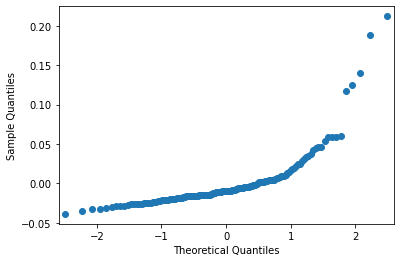

In [45]:
universal_correlation(df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric="OLS"
                     )

Clearly violates the assumptions of linear regression!

###### Per term

In [46]:
correlation(df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var2="gch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "spearman").sort_values(by="Word")

,Word,Correlation,p,N
6,A1_globalistisk,-0.815,0.000,14
2,N1_berikare,-0.897,0.000,16
3,N1_förortsgäng,-0.714,0.071,7
7,N1_globalist,-0.743,0.001,17
0,N1_kulturberikare,-0.540,0.017,19
5,N1_återvandring,-0.785,0.000,16
10,N2_återvandrare,NaN,NaN,0
1,V1_berika,-0.564,0.006,22
9,V1_hjälpa_på_plats,-0.736,0.004,13
4,V1_kulturberika,-0.888,0.000,16


N1_kulturberikare
V1_berika
N1_berikare
N1_förortsgäng
V1_kulturberika
N1_återvandring
A1_globalistisk
N1_globalist
V1_återvandra
V1_hjälpa_på_plats


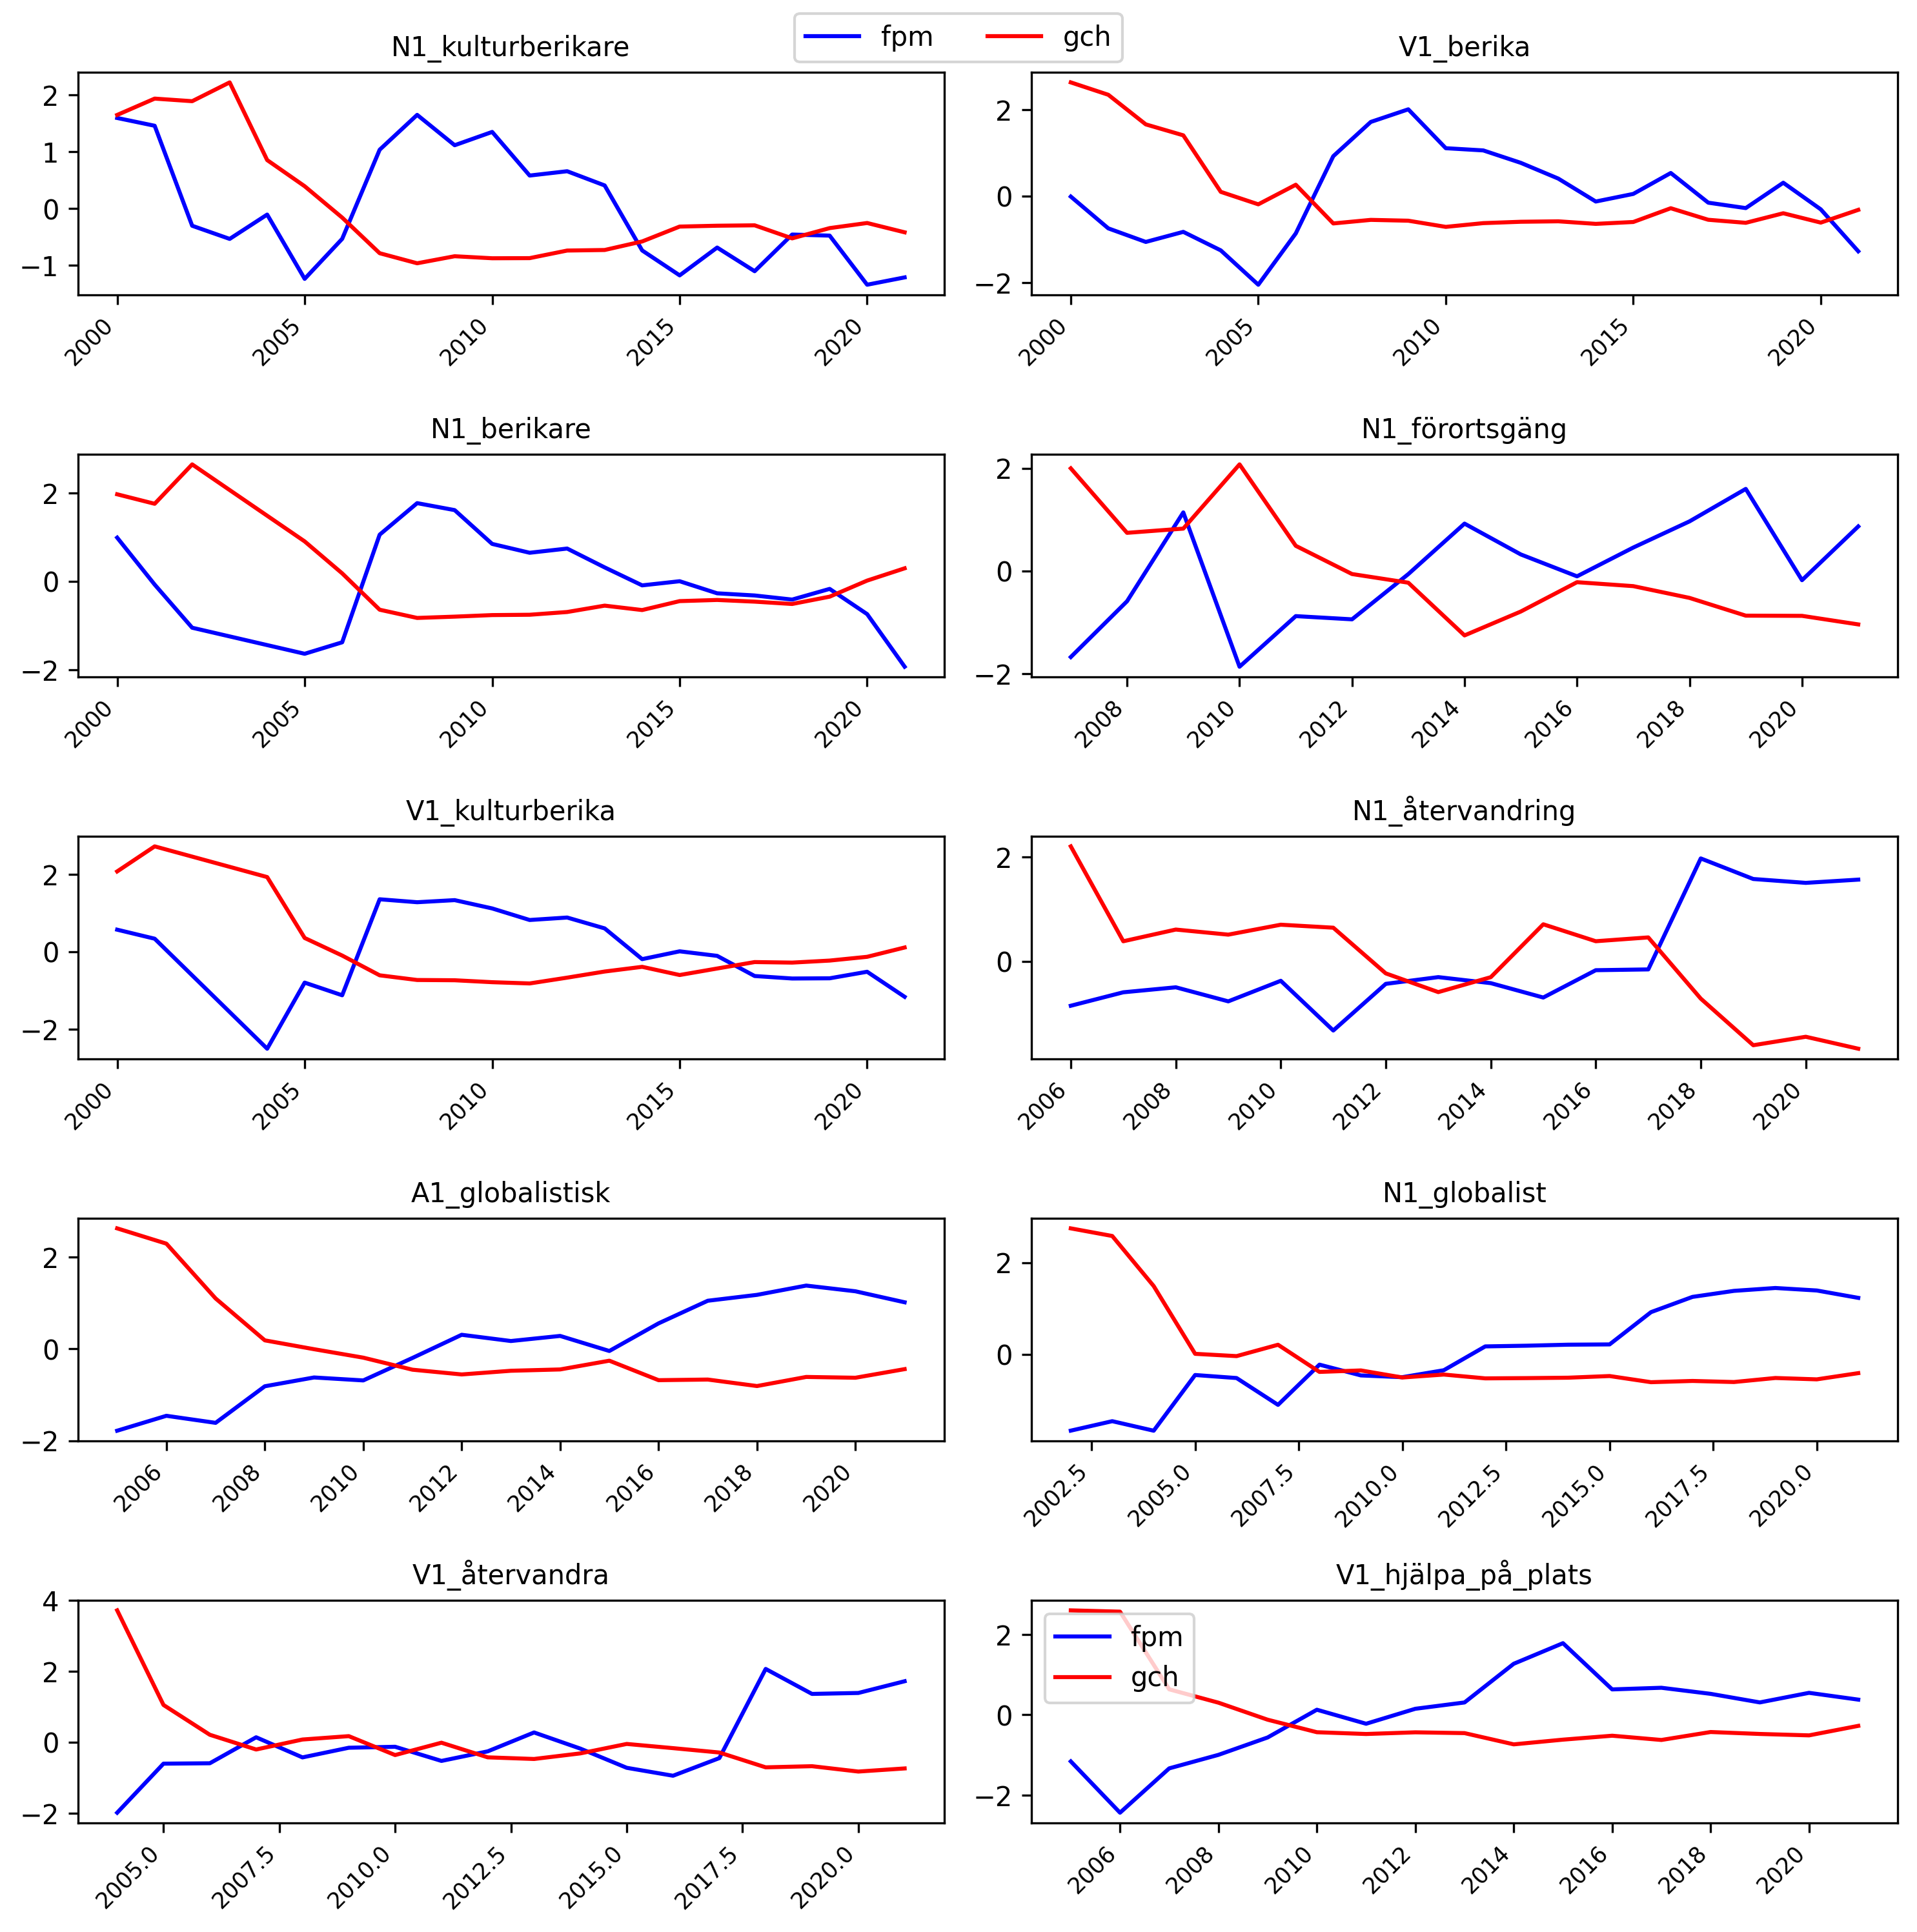

In [47]:
vis_cor(df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="gch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

N1_kulturberikare
V1_berika
N1_berikare
N1_förortsgäng
V1_kulturberika
N1_återvandring
P1_självständig_utrikespolitik
N1_globalist
V1_återvandra
V1_hjälpa_på_plats


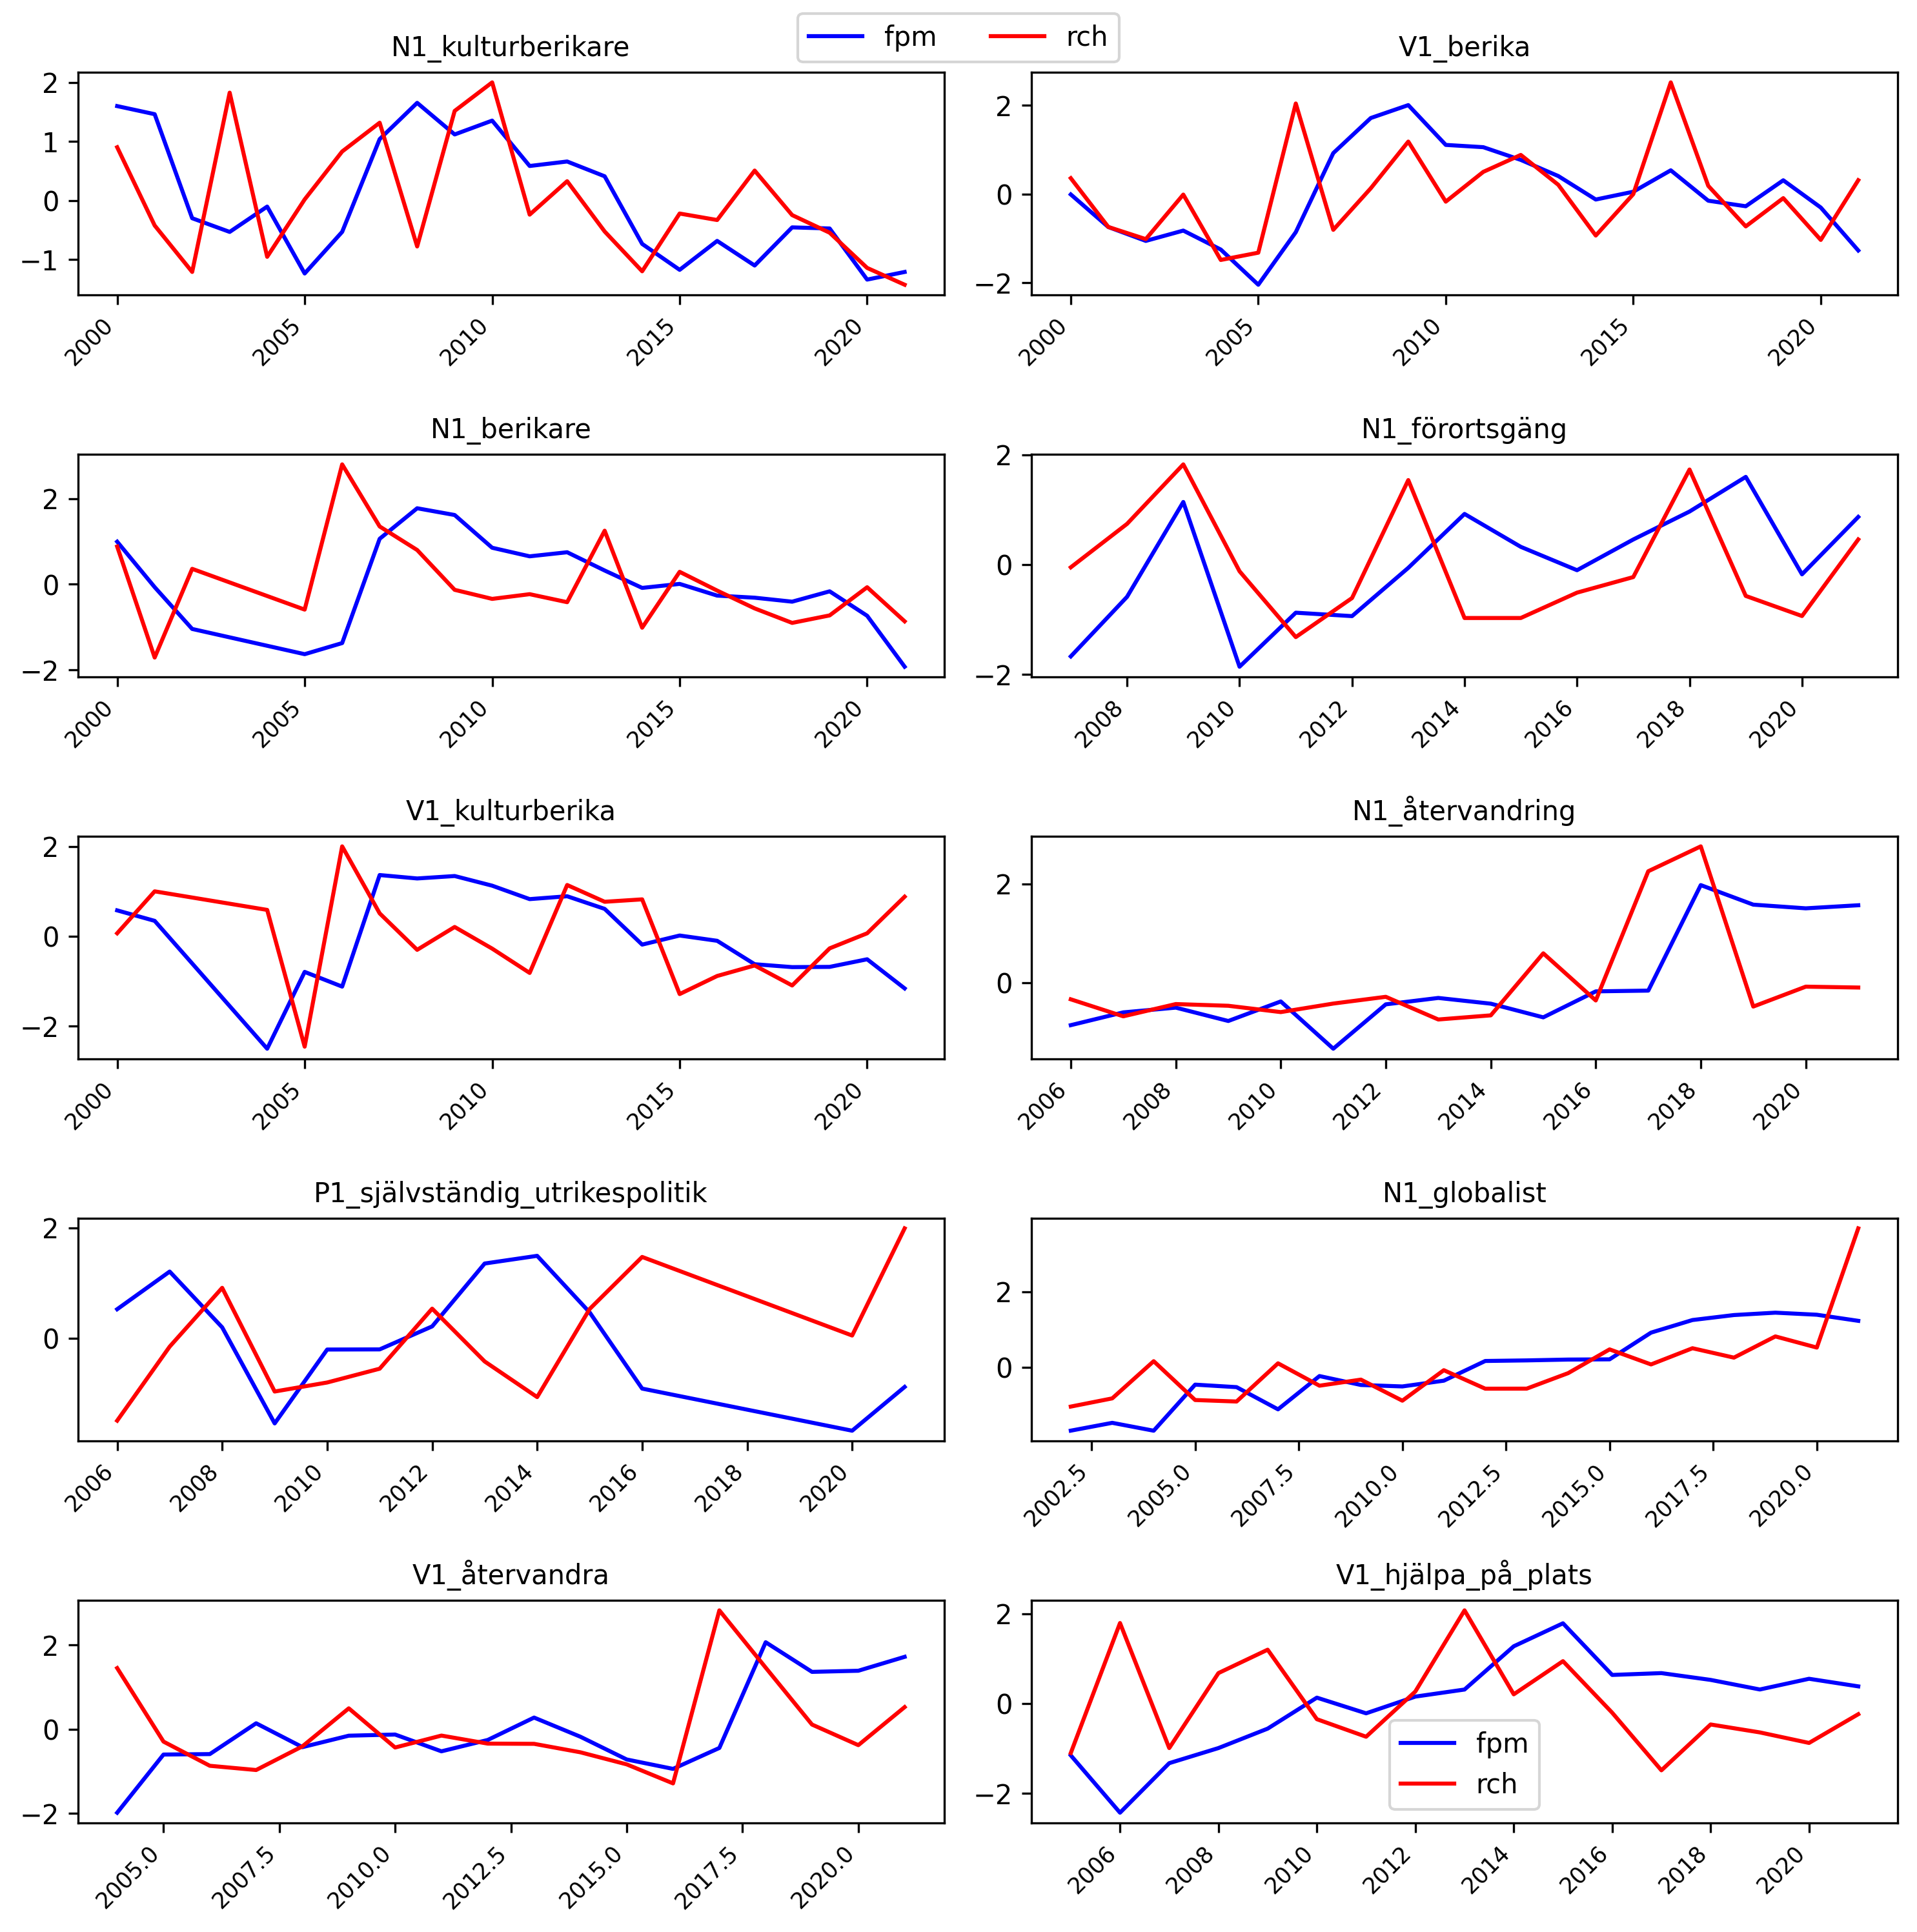

In [48]:
vis_cor(
    df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_" "A1_", "V1_", "P1_"))],:], 
    var1="fpm", 
    var2="rch", 
    var1tr = False, 
    var2tr = True, 
    prenorm1 = np.log,
    prenorm2 = None,
    norm1=zscore,
    norm2=zscore)

###### RECTIFIED: opposite relationship to that of GCH (and law of c.): positive correlation; if at all

In [49]:
universal_correlation(df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric="spearman"
                     )

(0.5668568538508953, 1.2195084844474268e-14)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     55.13
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           7.20e-12
Time:                        09:22:51   Log-Likelihood:                -475.30
No. Observations:                 156   AIC:                             954.6
Df Residuals:                     154   BIC:                             960.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6560      0.634      1.034      0.3

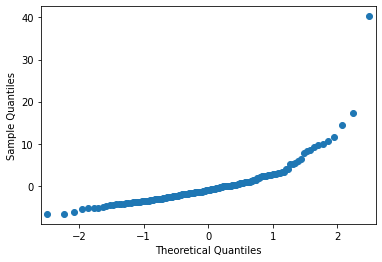

In [50]:
universal_correlation(df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric="OLS"
                     )

In [ ]:
vis_cor(df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
        var1="fpm", 
        var1tr = False,
        var2="rch",
        prenorm1=np.log,
        norm1=zscore,
        norm2=zscore,
       )

##### Difference in freq.

In [51]:
universal_correlation(df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "divfpm", 
                      "rch", 
                      norm1=np.log,
                      min_freq = 10
                     )

(0.23501603920538056, 0.002609187777972267)

###### Per term

However, no sign. relationship for:
* V1_berika
* V1_kulturberika
* N1_förortsgäng
* A1_globalistisk (p = 0.05)
* V1_hjälpa_på_plats
* N2_återvandrare

In [52]:
correlation(df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var2="rch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "pearson").sort_values(by="Word")

,Word,Correlation,p,N
6,A1_globalistisk,0.351,0.218,14
2,N1_berikare,0.054,0.841,16
3,N1_förortsgäng,0.069,0.883,7
7,N1_globalist,0.592,0.012,17
0,N1_kulturberikare,0.541,0.017,19
5,N1_återvandring,0.400,0.125,16
10,N2_återvandrare,NaN,NaN,0
1,V1_berika,0.406,0.061,22
9,V1_hjälpa_på_plats,0.010,0.975,13
4,V1_kulturberika,-0.087,0.749,16


In [ ]:
vis_cor(df=df_bert_kb.loc[[w for w in df_bert_kb.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="rch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

In [ ]:
vis_u_cor(
    df=df_bert_kb, 
    var1="rch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = 0, 
    norm1=None, 
    norm2=np.log, 
    top_n = 10000,
    min_freq = None, 
    alpha=0.3
)

In [ ]:
vis_u_cor(
    df=df_bert_kb, 
    var1="rch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = 0, 
    norm1=None, 
    norm2=np.log, 
    top_n = 10000,
    min_freq = None
)

_____________________________

### B2(a). STS (small)

* Confirms *law of confirmity* for GCH. 
* The effect disappears with RCH; compare Duborssarsky.

##### GENUINE: law of confirmity confirmed

... cut first

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "gch", 
                      0, 
                      norm1=np.log,
                      min_freq = 10
                     )

... cut last

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 10
                     )

###### Per term

In [ ]:
correlation(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var2="gch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "pearson")

In [ ]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="gch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

In [ ]:
vis_cor(
    df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_" "A1_", "V1_", "P1_"))],:], 
    var1="rch", 
    var2="fpm", 
    var1tr = True, 
    var2tr = False, 
    prenorm1 = None,
    prenorm2 = np.log,
    norm1=zscore,
    norm2=zscore)

###### RECTIFIED: opposite relationship to that of GCH (and law of c.): positive correlation; if at all

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "rch", 
                      0, 
                      norm1=np.log,
                      min_freq = 10
                     )

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 10
                     )

In [ ]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="rch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

##### Difference in freq.

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "divfpm", 
                      "rch", 
                      norm1=np.log,
                      min_freq = 10
                     )

###### Per term

However, no sign. relationship for:
* V1_berika
* V1_kulturberika
* N1_förortsgäng
* A1_globalistisk (p = 0.05)
* V1_hjälpa_på_plats
* N2_återvandrare

In [ ]:
correlation(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var2="rch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "pearson")

In [ ]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="rch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

###### Final notes on Std., means and RCH X GCH

The smaller the standard deviation, the larger RCH. As expected, since RCH is defined in those terms, but RCH is not strongly nor positively correlated with GCH! 

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "stdc", 
                      "rch", 
                      norm1=None,
                      min_freq = 100
                     )

The smaller the control mean, the larger RCH

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "mccc", 
                      "rch", 
                      norm1=None,
                      min_freq = 100
                     )

Unlike the SGNS models, RCH and GCH are *poorly* correlated

In [ ]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "gch", 
                      "rch", 
                      norm1=None,
                      min_freq = 10
                     )

RCH with somtimes very small GCH; consider esp. from 2006 onwards (V1_berika, N1_berikare, N1_globalist, N1_återvandring, etc.):

In [ ]:
q_show(df_bert_sts, "rch", as_table = True)

### B3 

##### GENUINE: law of confirmity confirmed

... cut last

In [ ]:
universal_correlation(df_cluster.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "kms", 
                      1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric = "pearson"
                     )

In [ ]:
universal_correlation(df_cluster.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "kms", 
                      1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric = "spearman"
                     )

In [ ]:
universal_correlation(df_cluster.loc[[w for w in df_bert_sts.index if w.startswith(("N1_", "N2_", "A1_", "V1_"))],:], 
                      "fpm", 
                      "kms", 
                      1, 
                      norm1=np.log,
                      min_freq = 11,
                      metric = "OLS"
                     )